In [1]:
!pip install --upgrade pip
!pip install tonic torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 25.1.1
    Uninstalling pip-25.1.1:
      Successfully uninstalled pip-25.1.1


## Imports

In [129]:
# ===========================
# Standard Libraries
# ===========================
import os
import random
from collections import defaultdict
import time

# ===========================
# Data Handling
# ===========================
import numpy as np
import pandas as pd
import h5py

# ===========================
# Visualization
# ===========================
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns

# ===========================
# Progress Bar
# ===========================
from tqdm import tqdm

# ===========================
# Machine Learning & PyTorch
# ===========================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

# ===========================
# Spiking Neural Networks
# ===========================
import snntorch as snn
from snntorch import surrogate

# ===========================
# Event-based Data (Tonic)
# ===========================
import tonic
from tonic import datasets
import tonic.transforms as transforms
from tonic.datasets import NMNIST

# ===========================
# Clustering & Metrics
# ===========================
from sklearn.cluster import DBSCAN
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_fscore_support
from sklearn.preprocessing import label_binarize

In [2]:
!pip install seaborn

## Loading the N-MNIST Dataset

In [ ]:
# Load the training set
nmnist_train = datasets.NMNIST(save_to="datasets/N-MNIST", train=True)

for i in range(len(nmnist_train)):
    events, label = nmnist_train[i]
    if label == 0:
        print(f"Found digit 0 at index {i}")
        break

# Check event structure
print("Event stream dtype:", events.dtype)
print("Total events:", len(events))
print("First 5 events:\n", events[:5])

events_np = np.stack([events['x'], events['y'], events['t'], events['p']], axis=1)
print("Converted shape:", events_np.shape)
print("First 5 [x, y, t, p] rows:\n", events_np[:5])

Found digit 0 at index 0
Event stream dtype: [('x', '<i8'), ('y', '<i8'), ('t', '<i8'), ('p', '<i8')]
Total events: 5028
First 5 events:
 [(10, 30,  937, 1) (33, 20, 1030, 1) (12, 27, 1052, 1) (33,  3, 2078, 1)
 (14, 23, 2383, 0)]
Converted shape: (5028, 4)
First 5 [x, y, t, p] rows:
 [[  10   30  937    1]
 [  33   20 1030    1]
 [  12   27 1052    1]
 [  33    3 2078    1]
 [  14   23 2383    0]]


## Visualizing Spike Positions and Distributions for Digit 0

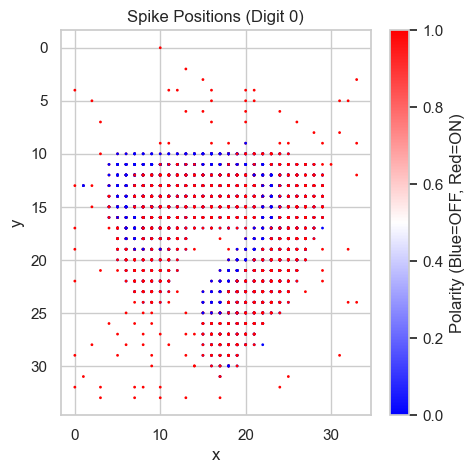

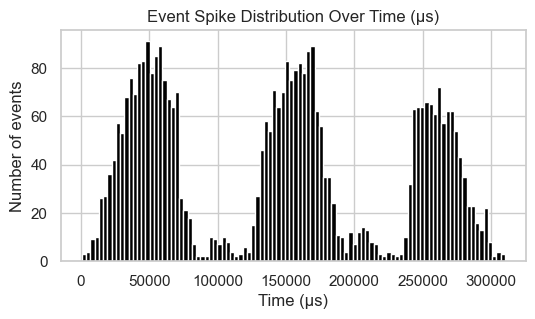

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# --------------- 1. 🔍 Visualize spike positions ----------------
plt.figure(figsize=(5, 5))
plt.scatter(events_np[:, 0], events_np[:, 1], c=events_np[:, 3], cmap='bwr', s=1)
plt.gca().invert_yaxis()
plt.title("Spike Positions (Digit 0)")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar(label="Polarity (Blue=OFF, Red=ON)")
plt.show()

# --------------- 2. ⌛ Plot time histogram ----------------
plt.figure(figsize=(6, 3))
plt.hist(events_np[:, 2], bins=100, color='black')
plt.title("Event Spike Distribution Over Time (µs)")
plt.xlabel("Time (µs)")
plt.ylabel("Number of events")
plt.show()

## Balanced Subset Selection

In [ ]:
# === COMMON CONFIG ===
sensor_size = NMNIST.sensor_size
num_samples = 10000        # total subset size
num_classes = 10
samples_per_class = num_samples // num_classes  # 1000 per digit
save_dir = './compressed_datasets'
os.makedirs(save_dir, exist_ok=True)

trainset = NMNIST(save_to='./', train=True)

# ---------------------------
# BALANCED SUBSET SELECTION
# ---------------------------
class_indices = defaultdict(list)
print("Scanning dataset for class indices...")

for idx in range(len(trainset)):
    _, label = trainset[idx]
    class_indices[int(label)].append(idx)

for c in range(num_classes):
    print(f"Digit {c}: {len(class_indices[c])} samples available")

balanced_indices = []
for c in range(num_classes):
    chosen = random.sample(class_indices[c], samples_per_class)
    balanced_indices.extend(chosen)

random.shuffle(balanced_indices)
print(f"✅ Balanced subset of {len(balanced_indices)} samples selected\n")

Scanning dataset for class indices...
Digit 0: 5923 samples available
Digit 1: 6742 samples available
Digit 2: 5958 samples available
Digit 3: 6131 samples available
Digit 4: 5842 samples available
Digit 5: 5421 samples available
Digit 6: 5918 samples available
Digit 7: 6265 samples available
Digit 8: 5851 samples available
Digit 9: 5949 samples available
✅ Balanced subset of 10000 samples selected



## Compression Technique 1 : Grid Based Compression

In [9]:
# ---------------------------
# GRID COMPRESSION FUNCTION
# ---------------------------
def grid_filter(events, grid_size=(10, 10), k=30, sensor_size=(34, 34)):
    """Filter events using a grid and select top-k per cell by timestamp."""
    h, w = sensor_size[:2]
    gx, gy = grid_size
    grid_w, grid_h = w // gx, h // gy
    keep_indices = []

    for i in range(gx):
        for j in range(gy):
            x_min, x_max = i * grid_w, (i + 1) * grid_w
            y_min, y_max = j * grid_h, (j + 1) * grid_h
            mask = (
                (events[:, 0] >= x_min) & (events[:, 0] < x_max) &
                (events[:, 1] >= y_min) & (events[:, 1] < y_max)
            )
            cell_events = events[mask]
            if len(cell_events) > 0:
                topk = np.argsort(cell_events[:, 2])[-k:]  # Keep k latest events
                keep_indices.extend(np.where(mask)[0][topk])
    return np.array(keep_indices)

# ---------------------------
# RUN GRID COMPRESSION
# ---------------------------
grid_hdf5_path = os.path.join(save_dir, 'grid_compressed_nmnist_balanced_10000.h5')
grid_summary_csv = os.path.join(save_dir, 'grid_compression_summary_balanced.csv')
grid_summary = []

with h5py.File(grid_hdf5_path, 'w') as h5f:
    for idx in tqdm(balanced_indices, desc="Balanced Grid Compression"):
        events, label = trainset[idx]
        events_np = np.stack([
            events['x'].astype(np.float32),
            events['y'].astype(np.float32),
            events['t'].astype(np.float32),
            events['p'].astype(np.float32)
        ], axis=1)

        # Normalize timestamps
        events_np[:, 2] /= events_np[:, 2].max() + 1e-8

        # Apply Grid Filter
        keep_indices = grid_filter(events_np, grid_size=(10, 10), k=30, sensor_size=sensor_size)
        filtered_events = events_np[keep_indices]
        discarded_events = events_np[np.setdiff1d(np.arange(len(events_np)), keep_indices)]

        if len(filtered_events) == 0:
            continue

        # Save to HDF5
        grp = h5f.create_group(f'sample_{idx}')
        grp.create_dataset('events', data=filtered_events, compression="gzip")
        grp.create_dataset('discarded', data=discarded_events, compression="gzip")
        grp.attrs['label'] = int(label)
        grp.attrs['sensor_size'] = sensor_size
        grp.attrs['original_event_count'] = len(events_np)
        grp.attrs['filtered_event_count'] = len(filtered_events)
        grp.attrs['compression_ratio'] = len(events_np) / len(filtered_events)

        # Log to summary
        grid_summary.append({
            'sample_index': idx,
            'label': int(label),
            'original_events': len(events_np),
            'filtered_events': len(filtered_events),
            'compression_ratio': len(events_np) / len(filtered_events)
        })

# Save CSV
pd.DataFrame(grid_summary).to_csv(grid_summary_csv, index=False)
avg_ratio = np.mean([row['compression_ratio'] for row in grid_summary])
print(f"\n✅ Balanced Grid compression complete. Summary saved to {grid_summary_csv}")
print(f"Average compression ratio: {avg_ratio:.2f}x")

Balanced Grid Compression: 100%|██████████| 10000/10000 [00:45<00:00, 222.05it/s]


✅ Balanced Grid compression complete. Summary saved to ./compressed_datasets/grid_compression_summary_balanced.csv
Average compression ratio: 3.07x


## Compression Technique 2 : DBSCAN Compression

In [ ]:
# ---------------------------
# DBSCAN COMPRESSION FUNCTION (Less Aggressive)
# ---------------------------
def dbscan_filter(events, eps=0.4, min_samples=3):
    """
    Compress events using DBSCAN on (x, y, t) with low compression.
    Keeps cluster centroids as representative events.
    """
    coords = events[:, :3]  # (x, y, t)
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(coords)
    labels = clustering.labels_
    
    filtered = []
    for lbl in np.unique(labels):
        if lbl == -1:  # Skip noise
            continue
        cluster_points = events[labels == lbl]
        centroid = cluster_points.mean(axis=0)
        filtered.append(centroid)
    return np.array(filtered, dtype=np.float32)

# ---------------------------
# RUN BALANCED DBSCAN COMPRESSION
# ---------------------------
dbscan_hdf5_path = os.path.join(save_dir, 'dbscan_compressed_nmnist_balanced_low_10000.h5')
dbscan_summary_csv = os.path.join(save_dir, 'dbscan_compression_summary_balanced_low.csv')
dbscan_summary = []

with h5py.File(dbscan_hdf5_path, 'w') as h5f:
    for idx in tqdm(balanced_indices, desc="Balanced DBSCAN Compression (Low)"):
        events, label = trainset[idx]
        events_np = np.stack([
            events['x'].astype(np.float32),
            events['y'].astype(np.float32),
            events['t'].astype(np.float32),
            events['p'].astype(np.float32)
        ], axis=1)

        # Normalize timestamps
        events_np[:, 2] /= events_np[:, 2].max() + 1e-8

        # Apply DBSCAN filter
        filtered_events = dbscan_filter(events_np, eps=0.4, min_samples=3)
        discarded_events = np.empty((0, 4), dtype=np.float32)

        if len(filtered_events) == 0:
            continue

        # Save to HDF5
        grp = h5f.create_group(f'sample_{idx}')
        grp.create_dataset('events', data=filtered_events, compression="gzip")
        grp.create_dataset('discarded', data=discarded_events, compression="gzip")
        grp.attrs['label'] = int(label)
        grp.attrs['sensor_size'] = sensor_size
        grp.attrs['original_event_count'] = len(events_np)
        grp.attrs['filtered_event_count'] = len(filtered_events)
        grp.attrs['compression_ratio'] = len(events_np) / len(filtered_events)

        dbscan_summary.append({
            'sample_index': idx,
            'label': int(label),
            'original_events': len(events_np),
            'filtered_events': len(filtered_events),
            'compression_ratio': len(events_np) / len(filtered_events)
        })

# Save CSV and print summary
pd.DataFrame(dbscan_summary).to_csv(dbscan_summary_csv, index=False)
avg_ratio = np.mean([row['compression_ratio'] for row in dbscan_summary])
avg_events = np.mean([row['filtered_events'] for row in dbscan_summary])

print(f"\n✅ Balanced DBSCAN compression complete. Summary saved to {dbscan_summary_csv}")
print(f"Average compression ratio: {avg_ratio:.2f}x")
print(f"Average filtered events per sample: {avg_events:.1f}")

Balanced DBSCAN Compression (Low): 100%|██████████| 10000/10000 [02:52<00:00, 57.83it/s]



✅ Balanced DBSCAN compression complete. Summary saved to ./compressed_datasets/dbscan_compression_summary_balanced_low.csv
Average compression ratio: 10.89x
Average filtered events per sample: 379.4


## Compression Technique 3 : Voxelization

In [ ]:
# ---------------------------
# VOXELIZATION COMPRESSION FUNCTION
# ---------------------------
def voxel_compression(events, time_bins=25, spatial_downsample=2, sensor_size=(34,34)):
    """
    Compress events by voxelizing in time and downsampling spatially.
    """
    if len(sensor_size) == 3:
        _, H, W = sensor_size
    else:
        H, W = sensor_size

    H_ds, W_ds = H // spatial_downsample, W // spatial_downsample
    
    # Normalize time to [0,1]
    t_norm = events[:,2] / (events[:,2].max() + 1e-8)
    t_bin = np.floor(t_norm * (time_bins-1)).astype(int)
    
    # Downsample spatial coordinates
    x_ds = (events[:,0] // spatial_downsample).astype(int)
    y_ds = (events[:,1] // spatial_downsample).astype(int)
    
    # Create voxel grid key (t, y, x, polarity)
    voxel_keys = np.stack([t_bin, y_ds, x_ds, events[:,3].astype(int)], axis=1)
    
    uniq_keys, inv_idx = np.unique(voxel_keys, axis=0, return_inverse=True)
    filtered_events = []
    for voxel_id in range(len(uniq_keys)):
        cluster_points = events[inv_idx == voxel_id]
        centroid = cluster_points.mean(axis=0)
        filtered_events.append(centroid)
    
    return np.array(filtered_events, dtype=np.float32)

# ---------------------------
# RUN BALANCED VOXELIZATION COMPRESSION
# ---------------------------

voxel_hdf5_path = os.path.join(save_dir, 'voxel_compressed_nmnist_balanced_10000.h5')
voxel_summary_csv = os.path.join(save_dir, 'voxel_compression_summary_balanced.csv')
voxel_summary = []

with h5py.File(voxel_hdf5_path, 'w') as h5f:
    for idx in tqdm(balanced_indices, desc="Balanced Voxel Compression"):
        events, label = trainset[idx]
        events_np = np.stack([
            events['x'].astype(np.float32),
            events['y'].astype(np.float32),
            events['t'].astype(np.float32),
            events['p'].astype(np.float32)
        ], axis=1)

        # Apply Voxelization
        filtered_events = voxel_compression(events_np, 
                                           time_bins=25, 
                                           spatial_downsample=2, 
                                           sensor_size=sensor_size)
        
        discarded_events = np.empty((0,4), dtype=np.float32)  # placeholder

        if len(filtered_events) == 0:
            continue

        # Save to HDF5
        grp = h5f.create_group(f'sample_{idx}')
        grp.create_dataset('events', data=filtered_events, compression="gzip")
        grp.create_dataset('discarded', data=discarded_events, compression="gzip")
        grp.attrs['label'] = int(label)
        grp.attrs['sensor_size'] = sensor_size
        grp.attrs['original_event_count'] = len(events_np)
        grp.attrs['filtered_event_count'] = len(filtered_events)
        grp.attrs['compression_ratio'] = len(events_np) / len(filtered_events)

        # Log to summary
        voxel_summary.append({
            'sample_index': idx,
            'label': int(label),
            'original_events': len(events_np),
            'filtered_events': len(filtered_events),
            'compression_ratio': len(events_np) / len(filtered_events)
        })

# Save CSV and print summary
pd.DataFrame(voxel_summary).to_csv(voxel_summary_csv, index=False)
avg_ratio = np.mean([row['compression_ratio'] for row in voxel_summary])
avg_events = np.mean([row['filtered_events'] for row in voxel_summary])

print(f"\n✅ Balanced Voxel compression complete. Summary saved to {voxel_summary_csv}")
print(f"Average compression ratio: {avg_ratio:.2f}x")
print(f"Average filtered events per sample: {avg_events:.1f}")

Balanced Voxel Compression: 100%|██████████| 10000/10000 [03:51<00:00, 43.18it/s]


✅ Balanced Voxel compression complete. Summary saved to ./compressed_datasets/voxel_compression_summary_balanced.csv
Average compression ratio: 3.25x
Average filtered events per sample: 1270.8


## Evaluation Metrics for the 3 Compression Methods

,Method,Compression Ratio (x),Events per Sample,Data Retention (%),Compressed Size (MB),Original Size (MB)
1,Grid (Top-K),3.120000,1342.816000,32.046000,214.850000,670.438000
2,DBSCAN,11.045000,379.364000,9.054000,60.698000,670.438000
3,Voxelization,3.297000,1270.766000,30.327000,203.323000,670.438000


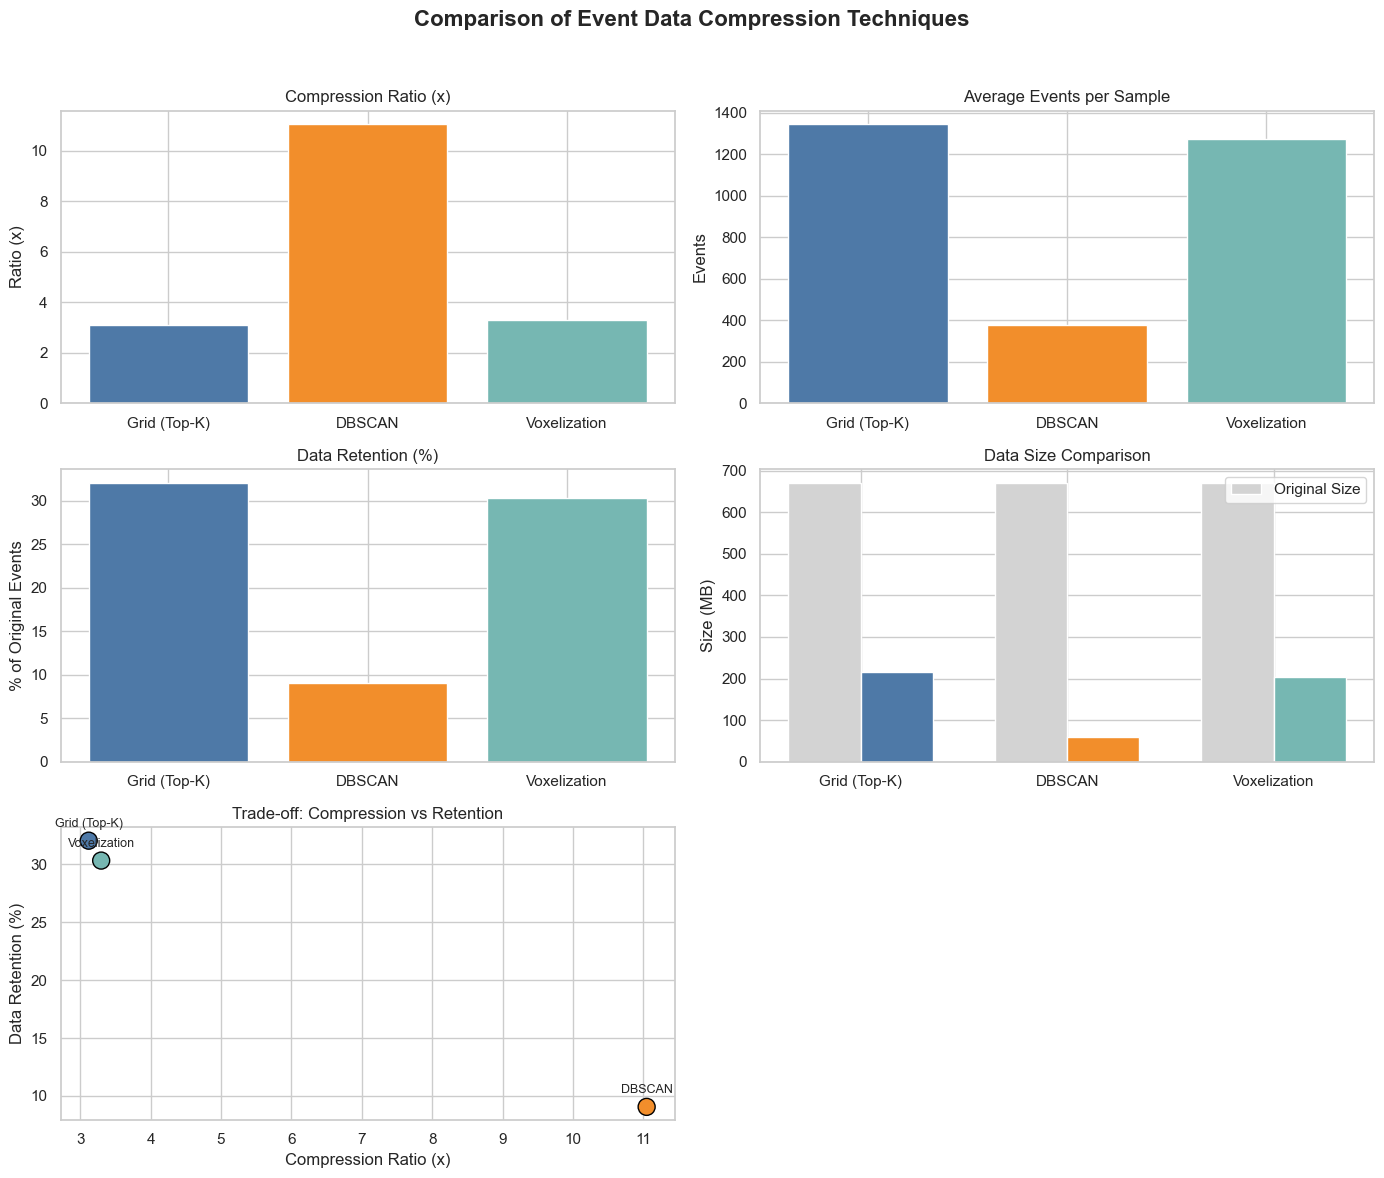

In [ ]:
grid_csv = './compressed_datasets/grid_compression_summary_balanced.csv'
dbscan_csv = './compressed_datasets/dbscan_compression_summary_balanced.csv'
voxel_csv = './compressed_datasets/voxel_compression_summary_balanced.csv'

dfs = [pd.read_csv(grid_csv), pd.read_csv(dbscan_csv), pd.read_csv(voxel_csv)]
methods = ["Grid (Top-K)", "DBSCAN", "Voxelization"]

# === Compute summary metrics dynamically ===
summary = []
original_event_count = dfs[0]["original_events"].sum()
original_size_mb = (original_event_count * 16 / 1e6)  

for method, df in zip(methods, dfs):
    total_events = df["filtered_events"].sum()
    avg_events = df["filtered_events"].mean()
    compression_ratio = df["original_events"].sum() / total_events
    data_retention = (total_events / df["original_events"].sum()) * 100
    compressed_size_mb = total_events * 16 / 1e6  # 16 bytes/event

    summary.append([method, compression_ratio, avg_events, data_retention, compressed_size_mb, original_size_mb])

columns = ["Method", "Compression Ratio (x)", "Events per Sample", "Data Retention (%)", 
           "Compressed Size (MB)", "Original Size (MB)"]

df_summary = pd.DataFrame(summary, columns=columns)
df_summary_rounded = df_summary.round(3)

# Make index start from 1
df_summary_rounded.index = np.arange(1, len(df_summary_rounded) + 1)

# === Styled Table for Dark Mode ===
styles = [
    {'selector': 'thead th', 
     'props': [('background-color', '#333333'), 
               ('color', 'white'), 
               ('font-weight', 'bold'), 
               ('text-align', 'center')]},
    {'selector': 'tbody tr:nth-child(even)', 
     'props': [('background-color', '#444444'), 
               ('color', 'white')]},
    {'selector': 'tbody tr:nth-child(odd)', 
     'props': [('background-color', '#222222'), 
               ('color', 'white')]}
]

display(df_summary_rounded.style
        .set_table_styles(styles)
        .set_properties(**{'text-align': 'center'}))

# === Sequential Plots ===
colors = ['#4E79A7', '#F28E2B', '#76B7B2']

fig, axs = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle("Comparison of Event Data Compression Techniques", fontsize=16, fontweight='bold')

# 1. Compression Ratio
axs[0,0].bar(df_summary["Method"], df_summary["Compression Ratio (x)"], color=colors)
axs[0,0].set_ylabel("Ratio (x)")
axs[0,0].set_title("Compression Ratio (x)")

# 2. Average Events per Sample
axs[0,1].bar(df_summary["Method"], df_summary["Events per Sample"], color=colors)
axs[0,1].set_ylabel("Events")
axs[0,1].set_title("Average Events per Sample")

# 3. Data Retention
axs[1,0].bar(df_summary["Method"], df_summary["Data Retention (%)"], color=colors)
axs[1,0].set_ylabel("% of Original Events")
axs[1,0].set_title("Data Retention (%)")

# 4. Data Size Comparison
width = 0.35
x = np.arange(len(df_summary))
axs[1,1].bar(x - width/2, df_summary["Original Size (MB)"], width, color='lightgray', label='Original Size')
axs[1,1].bar(x + width/2, df_summary["Compressed Size (MB)"], width, color=colors)
axs[1,1].set_xticks(x)
axs[1,1].set_xticklabels(df_summary["Method"])
axs[1,1].set_ylabel("Size (MB)")
axs[1,1].set_title("Data Size Comparison")
axs[1,1].legend()

# 5. Compression vs Retention Trade-off
axs[2,0].scatter(df_summary["Compression Ratio (x)"], df_summary["Data Retention (%)"],
                 s=150, color=colors, edgecolor='black')
for i, method in enumerate(df_summary["Method"]):
    axs[2,0].annotate(method, 
                      (df_summary["Compression Ratio (x)"][i], df_summary["Data Retention (%)"][i]),
                      textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)
axs[2,0].set_xlabel("Compression Ratio (x)")
axs[2,0].set_ylabel("Data Retention (%)")
axs[2,0].set_title("Trade-off: Compression vs Retention")

# Hide unused subplot
axs[2,1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Compression Techniques : Event Reduction Statistics


=== Grid (Top-K) Compression Summary ===
Total samples: 10000
Original events (mean ± std): 4190.2 ± 1188.7
Compressed events (mean ± std): 1342.8 ± 245.8
Compression ratio (mean): 0.334
Average compression: 66.65% event reduction
Best (max) event reduction: 76.44%
Worst (min) event reduction: 23.44%

=== DBSCAN Compression Summary ===
Total samples: 10000
Original events (mean ± std): 4190.2 ± 1188.7
Compressed events (mean ± std): 379.4 ± 78.4
Compression ratio (mean): 0.093
Average compression: 90.67% event reduction
Best (max) event reduction: 93.07%
Worst (min) event reduction: 84.78%

=== Voxelization Compression Summary ===
Total samples: 10000
Original events (mean ± std): 4190.2 ± 1188.7
Compressed events (mean ± std): 1270.8 ± 255.7
Compression ratio (mean): 0.313
Average compression: 68.70% event reduction
Best (max) event reduction: 76.28%
Worst (min) event reduction: 39.07%


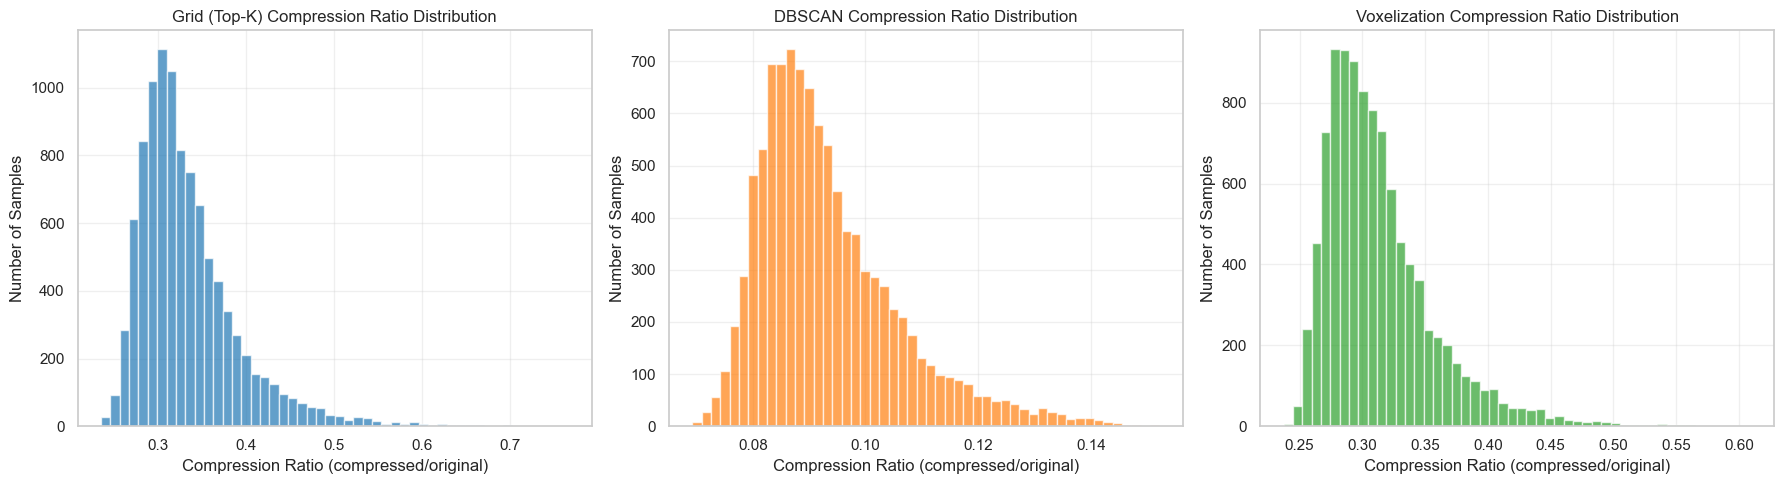

In [ ]:
# === CONFIG ===
compression_files = {
    "Grid (Top-K)": "./compressed_datasets/grid_compressed_nmnist_balanced_10000.h5",
    "DBSCAN": "./compressed_datasets/dbscan_compressed_nmnist_balanced_10000.h5",
    "Voxelization": "./compressed_datasets/voxel_compressed_nmnist_balanced_10000.h5"
}

method_stats = {}

plt.figure(figsize=(18, 5))
for idx, (method, file_path) in enumerate(compression_files.items(), 1):
    with h5py.File(file_path, 'r') as f:
        original_counts = []
        compressed_counts = []

        for key in f.keys():
            grp = f[key]
            orig = grp.attrs['original_event_count']
            comp = grp.attrs['filtered_event_count']
            original_counts.append(orig)
            compressed_counts.append(comp)

        original_counts = np.array(original_counts)
        compressed_counts = np.array(compressed_counts)

        compression_ratio = compressed_counts / original_counts  # compressed/original
        event_reduction = (1 - compression_ratio) * 100

        method_stats[method] = {
            "total_samples": len(original_counts),
            "original_mean": np.mean(original_counts),
            "original_std": np.std(original_counts),
            "compressed_mean": np.mean(compressed_counts),
            "compressed_std": np.std(compressed_counts),
            "mean_ratio": np.mean(compression_ratio),
            "mean_reduction": np.mean(event_reduction),
            "max_reduction": np.max(event_reduction),
            "min_reduction": np.min(event_reduction)
        }

        # === Print Stats ===
        print(f"\n=== {method} Compression Summary ===")
        print(f"Total samples: {len(original_counts)}")
        print(f"Original events (mean ± std): {np.mean(original_counts):.1f} ± {np.std(original_counts):.1f}")
        print(f"Compressed events (mean ± std): {np.mean(compressed_counts):.1f} ± {np.std(compressed_counts):.1f}")
        print(f"Compression ratio (mean): {np.mean(compression_ratio):.3f}")
        print(f"Average compression: {np.mean(event_reduction):.2f}% event reduction")
        print(f"Best (max) event reduction: {np.max(event_reduction):.2f}%")
        print(f"Worst (min) event reduction: {np.min(event_reduction):.2f}%")

        # === Plot Histogram of Compression Ratios ===
        plt.subplot(1, 3, idx)
        plt.hist(compression_ratio, bins=50, color=['#1f77b4','#ff7f0e','#2ca02c'][idx-1], alpha=0.7)
        plt.title(f"{method} Compression Ratio Distribution")
        plt.xlabel("Compression Ratio (compressed/original)")
        plt.ylabel("Number of Samples")
        plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Defining the Dataset Loader

In [ ]:
class HDF5CompressedEventDataset(Dataset):
    def __init__(self, h5_path, time_bins=25, sensor_size=(34, 34)):
        """
        HDF5 dataset loader with lazy file access to avoid pickling issues.
        Each worker will open the file only when accessing items.
        """
        self.h5_path = h5_path
        self.keys = list(h5py.File(h5_path, 'r').keys())  # store keys only
        self.time_bins = time_bins
        self.sensor_size = sensor_size

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        with h5py.File(self.h5_path, 'r') as file:
            group = file[self.keys[idx]]
            events = group['events'][()]
            label = group.attrs['label']

        voxel = self.events_to_voxel(events)
        return voxel, label

    def events_to_voxel(self, events):
        H, W = self.sensor_size
        T = self.time_bins
        voxel = np.zeros((T, 2, H, W), dtype=np.float32)

        # Normalize timestamps to [0, 1]
        t_norm = events[:, 2] / (events[:, 2].max() + 1e-9)
        t_scaled = (t_norm * (T - 1)).astype(np.int32)

        for x, y, t, p in zip(events[:, 0], events[:, 1], t_scaled, events[:, 3]):
            if 0 <= x < W and 0 <= y < H and 0 <= t < T:
                voxel[t, int(p), int(y), int(x)] += 1

        return torch.from_numpy(voxel)  # shape: (T, 2, H, W)

## Train-Test Split

In [ ]:
grid_h5 = "compressed_datasets/grid_compressed_nmnist_balanced_10000.h5"
dbscan_h5 = "compressed_datasets/dbscan_compressed_nmnist_balanced_10000.h5"
voxel_h5 = "compressed_datasets/voxel_compressed_nmnist_balanced_10000.h5"

# Common config
time_bins = 25
batch_size = 32
num_workers = 0

# Load datasets
grid_dataset = HDF5CompressedEventDataset(grid_h5, time_bins=time_bins)
dbscan_dataset = HDF5CompressedEventDataset(dbscan_h5, time_bins=time_bins)
voxel_dataset = HDF5CompressedEventDataset(voxel_h5, time_bins=time_bins)

datasets = {
    "Grid": grid_dataset,
    "DBSCAN": dbscan_dataset,
    "Voxel": voxel_dataset
}

# Dictionary to store train/val/test loaders for each method
loaders = {}

for name, dataset in datasets.items():
    total_len = len(dataset)
    test_size = int(0.2 * total_len)
    val_size = int(0.1 * total_len)
    train_size = total_len - test_size - val_size

    # Random split into train/val/test
    train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

    # Create DataLoaders
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader   = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    loaders[name] = {
        "train": train_loader,
        "val": val_loader,
        "test": test_loader
    }

    print(f"✅ {name} dataset: {total_len} samples | Train: {train_size} | Val: {val_size} | Test: {test_size}")

# Example usage:
# loaders["Grid"]["train"]
# loaders["DBSCAN"]["val"]
# loaders["Voxel"]["test"]

✅ Grid dataset: 10000 samples | Train: 7000 | Val: 1000 | Test: 2000
✅ DBSCAN dataset: 10000 samples | Train: 7000 | Val: 1000 | Test: 2000
✅ Voxel dataset: 10000 samples | Train: 7000 | Val: 1000 | Test: 2000


## Model 1 : SNN

In [ ]:
class SimpleEventSNN(nn.Module):
    def __init__(self, time_bins=25, num_classes=10):
        super().__init__()
        self.time_bins = time_bins
        self.beta = 0.9
        spike_grad = surrogate.fast_sigmoid()

        # Conv layers
        self.conv1 = nn.Conv3d(2, 16, kernel_size=(3,3,3), padding=1)
        self.lif1 = snn.Leaky(beta=self.beta, spike_grad=spike_grad)

        self.conv2 = nn.Conv3d(16, 32, kernel_size=(3,3,3), padding=1)
        self.lif2 = snn.Leaky(beta=self.beta, spike_grad=spike_grad)
        self.pool = nn.MaxPool3d((1,2,2))

        # ---- Dynamically compute fc1 input size ----
        with torch.no_grad():
            dummy = torch.zeros(1, 2, 1, 34, 34)  # (B, C, T=1, H, W)
            dummy = self.pool(self.conv2(self.conv1(dummy)))
            flat_dim = dummy.flatten(start_dim=1).shape[1]

        self.fc1 = nn.Linear(flat_dim, 128)
        self.lif3 = snn.Leaky(beta=self.beta, spike_grad=spike_grad)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # x: (B, T, 2, H, W)
        x = x.permute(0, 2, 1, 3, 4)  # -> (B, 2, T, H, W)

        # Initialize hidden states
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        spk_rec = []

        for step in range(x.size(2)):
            x_t = x[:, :, step, :, :].unsqueeze(2)  # (B, 2, 1, H, W)

            cur1 = self.conv1(x_t)
            spk1, mem1 = self.lif1(cur1, mem1)

            cur2 = self.pool(F.relu(self.conv2(spk1)))
            spk2, mem2 = self.lif2(cur2, mem2)

            flat = spk2.flatten(start_dim=1)
            cur3 = self.fc1(flat)
            spk3, mem3 = self.lif3(cur3, mem3)

            out = self.fc2(spk3)
            spk_rec.append(out)

        # Average over time
        return torch.stack(spk_rec).mean(0)

## SNN : Training Loop

In [ ]:
def train_single_dataset(model_class, loaders, device, num_epochs=20, lr=1e-3, patience=5, save_prefix="SimpleSNN"):

    results = {}

    for name, loader_dict in loaders.items():
        print(f"\n=== Training on {name} Dataset ===")

        # Initialize model
        model = model_class().to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        best_val_acc = 0.0
        epochs_no_improve = 0

        train_loader = loader_dict["train"]
        val_loader = loader_dict["val"]
        test_loader = loader_dict["test"]

        history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

        for epoch in range(num_epochs):
            # ----------------- Training -----------------
            model.train()
            running_loss, correct, total = 0.0, 0, 0

            for x, y in tqdm(train_loader, desc=f"{name} Epoch {epoch+1}/{num_epochs}", leave=False):
                x, y = x.to(device), y.to(device)

                optimizer.zero_grad()
                out = model(x)
                loss = criterion(out, y)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * x.size(0)
                _, predicted = out.max(1)
                total += y.size(0)
                correct += predicted.eq(y).sum().item()

            train_loss = running_loss / total
            train_acc = 100.0 * correct / total

            # ----------------- Validation -----------------
            model.eval()
            val_loss, val_correct, val_total = 0.0, 0, 0
            with torch.no_grad():
                for x, y in val_loader:
                    x, y = x.to(device), y.to(device)
                    out = model(x)
                    loss = criterion(out, y)

                    val_loss += loss.item() * x.size(0)
                    _, predicted = out.max(1)
                    val_total += y.size(0)
                    val_correct += predicted.eq(y).sum().item()

            val_loss /= val_total
            val_acc = 100.0 * val_correct / val_total

            history["train_loss"].append(train_loss)
            history["train_acc"].append(train_acc)
            history["val_loss"].append(val_loss)
            history["val_acc"].append(val_acc)

            print(f"[{name}] Epoch {epoch+1}/{num_epochs} "
                  f"| Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% "
                  f"| Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

            # Early Stopping
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                epochs_no_improve = 0
                torch.save(model.state_dict(), f"{save_prefix}_{name}_best.pth")
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print(f"⏹ Early stopping on {name} after {epoch+1} epochs.")
                    break

        # ----------------- Testing -----------------
        model.load_state_dict(torch.load(f"{save_prefix}_{name}_best.pth"))
        model.eval()
        test_loss, test_correct, test_total = 0.0, 0, 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)

                test_loss += loss.item() * x.size(0)
                _, predicted = out.max(1)
                test_total += y.size(0)
                test_correct += predicted.eq(y).sum().item()

        test_acc = 100.0 * test_correct / test_total
        test_loss /= test_total

        print(f"✅ {name} Test Accuracy: {test_acc:.2f}% | Test Loss: {test_loss:.4f}")

        results[name] = {
            "history": history,
            "test_acc": test_acc,
            "test_loss": test_loss
        }

    return results

device = torch.device("cpu")

results = train_single_dataset(
    model_class=SimpleEventSNN,
    loaders=loaders,       
    device=device,
    num_epochs=20,
    lr=1e-3,
    patience=5,
    save_prefix="SimpleSNN"
)


=== Training on Grid Dataset ===


[Grid] Epoch 1/20 | Train Loss: 1.3974, Acc: 58.27% | Val Loss: 0.7595, Acc: 81.80%


[Grid] Epoch 2/20 | Train Loss: 0.6471, Acc: 82.49% | Val Loss: 0.5584, Acc: 86.50%


[Grid] Epoch 3/20 | Train Loss: 0.4964, Acc: 86.51% | Val Loss: 0.4822, Acc: 87.90%


[Grid] Epoch 4/20 | Train Loss: 0.4202, Acc: 88.77% | Val Loss: 0.4222, Acc: 89.30%


[Grid] Epoch 5/20 | Train Loss: 0.3530, Acc: 90.50% | Val Loss: 0.3800, Acc: 89.30%


[Grid] Epoch 6/20 | Train Loss: 0.3184, Acc: 91.17% | Val Loss: 0.3501, Acc: 90.40%


[Grid] Epoch 7/20 | Train Loss: 0.2846, Acc: 92.39% | Val Loss: 0.3384, Acc: 91.20%


[Grid] Epoch 8/20 | Train Loss: 0.2543, Acc: 92.96% | Val Loss: 0.3119, Acc: 91.80%


[Grid] Epoch 9/20 | Train Loss: 0.2319, Acc: 93.73% | Val Loss: 0.2927, Acc: 91.60%


[Grid] Epoch 10/20 | Train Loss: 0.2129, Acc: 94.26% | Val Loss: 0.2654, Acc: 92.80%


[Grid] Epoch 11/20 | Train Loss: 0.1801, Acc: 95.09% | Val Loss: 0.2564, Acc: 92.80%


[Grid] Epoch 12/20 | Train Loss: 0.1605, Acc: 95.49% | Val Loss: 0.2402, Acc: 92.50%


[Grid] Epoch 13/20 | Train Loss: 0.1463, Acc: 95.96% | Val Loss: 0.2325, Acc: 93.00%


[Grid] Epoch 14/20 | Train Loss: 0.1278, Acc: 96.61% | Val Loss: 0.2255, Acc: 93.20%


[Grid] Epoch 15/20 | Train Loss: 0.1139, Acc: 97.23% | Val Loss: 0.2083, Acc: 94.40%


[Grid] Epoch 16/20 | Train Loss: 0.0975, Acc: 97.63% | Val Loss: 0.2257, Acc: 93.20%


[Grid] Epoch 17/20 | Train Loss: 0.0890, Acc: 97.93% | Val Loss: 0.2199, Acc: 92.90%


[Grid] Epoch 18/20 | Train Loss: 0.0760, Acc: 98.31% | Val Loss: 0.2124, Acc: 93.90%


[Grid] Epoch 19/20 | Train Loss: 0.0657, Acc: 98.67% | Val Loss: 0.2009, Acc: 93.60%


[Grid] Epoch 20/20 | Train Loss: 0.0586, Acc: 99.06% | Val Loss: 0.1953, Acc: 94.00%
⏹ Early stopping on Grid after 20 epochs.
✅ Grid Test Accuracy: 93.45% | Test Loss: 0.2040

=== Training on DBSCAN Dataset ===


[DBSCAN] Epoch 1/20 | Train Loss: 1.9666, Acc: 39.64% | Val Loss: 1.4806, Acc: 56.20%


[DBSCAN] Epoch 2/20 | Train Loss: 1.1560, Acc: 70.26% | Val Loss: 0.9828, Acc: 72.40%


[DBSCAN] Epoch 3/20 | Train Loss: 0.8970, Acc: 75.41% | Val Loss: 0.8673, Acc: 74.70%


[DBSCAN] Epoch 4/20 | Train Loss: 0.7930, Acc: 77.73% | Val Loss: 0.7915, Acc: 76.60%


[DBSCAN] Epoch 5/20 | Train Loss: 0.7110, Acc: 79.23% | Val Loss: 0.7460, Acc: 78.10%


[DBSCAN] Epoch 6/20 | Train Loss: 0.6799, Acc: 81.50% | Val Loss: 0.6768, Acc: 80.30%


[DBSCAN] Epoch 7/20 | Train Loss: 0.6099, Acc: 82.44% | Val Loss: 0.6219, Acc: 81.60%


[DBSCAN] Epoch 8/20 | Train Loss: 0.5723, Acc: 83.89% | Val Loss: 0.6114, Acc: 81.10%


[DBSCAN] Epoch 9/20 | Train Loss: 0.5710, Acc: 83.71% | Val Loss: 0.6162, Acc: 81.10%


[DBSCAN] Epoch 10/20 | Train Loss: 0.5467, Acc: 84.04% | Val Loss: 0.5909, Acc: 81.20%


[DBSCAN] Epoch 11/20 | Train Loss: 0.5214, Acc: 84.63% | Val Loss: 0.5473, Acc: 83.80%


[DBSCAN] Epoch 12/20 | Train Loss: 0.4812, Acc: 86.69% | Val Loss: 0.5375, Acc: 84.80%


[DBSCAN] Epoch 13/20 | Train Loss: 0.4887, Acc: 86.24% | Val Loss: 0.5209, Acc: 84.60%


[DBSCAN] Epoch 14/20 | Train Loss: 0.4426, Acc: 87.54% | Val Loss: 0.4998, Acc: 85.80%


[DBSCAN] Epoch 15/20 | Train Loss: 0.4215, Acc: 87.76% | Val Loss: 0.4808, Acc: 85.70%


[DBSCAN] Epoch 16/20 | Train Loss: 0.4207, Acc: 88.04% | Val Loss: 0.4894, Acc: 85.40%


[DBSCAN] Epoch 17/20 | Train Loss: 0.4098, Acc: 88.41% | Val Loss: 0.4623, Acc: 86.30%


[DBSCAN] Epoch 18/20 | Train Loss: 0.3791, Acc: 89.43% | Val Loss: 0.4455, Acc: 86.90%


[DBSCAN] Epoch 19/20 | Train Loss: 0.3718, Acc: 89.16% | Val Loss: 0.4429, Acc: 86.80%


[DBSCAN] Epoch 20/20 | Train Loss: 0.3686, Acc: 89.43% | Val Loss: 0.4455, Acc: 87.00%
✅ DBSCAN Test Accuracy: 88.60% | Test Loss: 0.4179

=== Training on Voxel Dataset ===


[Voxel] Epoch 1/20 | Train Loss: 1.3780, Acc: 57.04% | Val Loss: 0.7775, Acc: 77.70%


[Voxel] Epoch 2/20 | Train Loss: 0.6725, Acc: 82.34% | Val Loss: 0.5585, Acc: 83.90%


[Voxel] Epoch 3/20 | Train Loss: 0.5391, Acc: 85.66% | Val Loss: 0.5138, Acc: 86.80%


[Voxel] Epoch 4/20 | Train Loss: 0.4727, Acc: 87.73% | Val Loss: 0.4277, Acc: 88.90%


[Voxel] Epoch 5/20 | Train Loss: 0.4434, Acc: 88.01% | Val Loss: 0.4260, Acc: 88.30%


[Voxel] Epoch 6/20 | Train Loss: 0.4172, Acc: 88.50% | Val Loss: 0.3982, Acc: 89.40%


[Voxel] Epoch 7/20 | Train Loss: 0.3771, Acc: 89.63% | Val Loss: 0.3559, Acc: 90.30%


[Voxel] Epoch 8/20 | Train Loss: 0.3544, Acc: 90.40% | Val Loss: 0.3299, Acc: 90.90%


[Voxel] Epoch 9/20 | Train Loss: 0.3327, Acc: 90.59% | Val Loss: 0.3123, Acc: 91.00%


[Voxel] Epoch 10/20 | Train Loss: 0.3198, Acc: 91.60% | Val Loss: 0.2878, Acc: 92.60%


[Voxel] Epoch 11/20 | Train Loss: 0.3016, Acc: 92.06% | Val Loss: 0.2985, Acc: 92.30%


[Voxel] Epoch 12/20 | Train Loss: 0.2846, Acc: 91.89% | Val Loss: 0.2624, Acc: 93.20%


[Voxel] Epoch 13/20 | Train Loss: 0.2631, Acc: 92.89% | Val Loss: 0.2497, Acc: 93.00%


[Voxel] Epoch 14/20 | Train Loss: 0.2402, Acc: 93.47% | Val Loss: 0.2630, Acc: 92.40%


[Voxel] Epoch 15/20 | Train Loss: 0.2254, Acc: 93.69% | Val Loss: 0.2106, Acc: 94.00%


[Voxel] Epoch 16/20 | Train Loss: 0.2157, Acc: 94.21% | Val Loss: 0.2198, Acc: 94.30%


[Voxel] Epoch 17/20 | Train Loss: 0.2012, Acc: 94.49% | Val Loss: 0.2107, Acc: 93.80%


[Voxel] Epoch 18/20 | Train Loss: 0.1971, Acc: 94.90% | Val Loss: 0.2107, Acc: 94.10%


[Voxel] Epoch 19/20 | Train Loss: 0.1882, Acc: 94.77% | Val Loss: 0.2045, Acc: 94.30%


[Voxel] Epoch 20/20 | Train Loss: 0.1699, Acc: 95.20% | Val Loss: 0.1753, Acc: 94.90%
✅ Voxel Test Accuracy: 95.15% | Test Loss: 0.1628


## SNN Model : Loss and Accuracy Curves

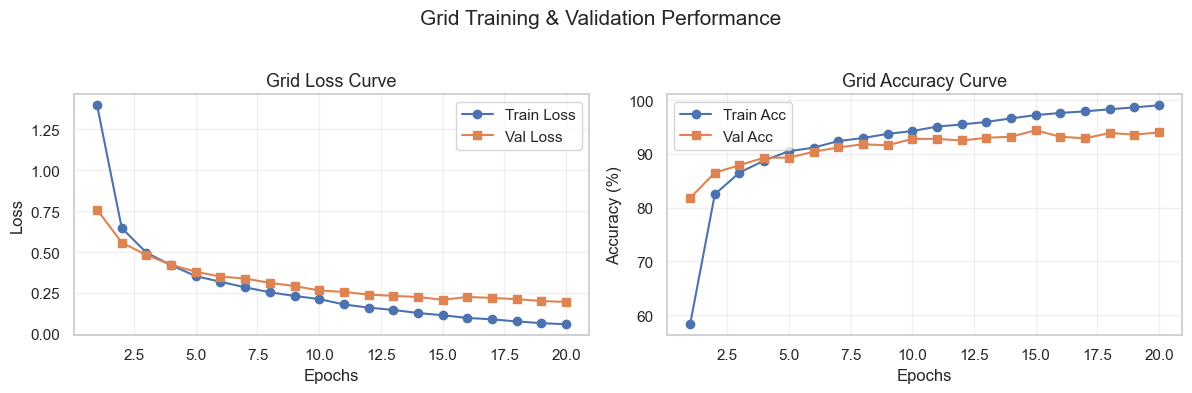

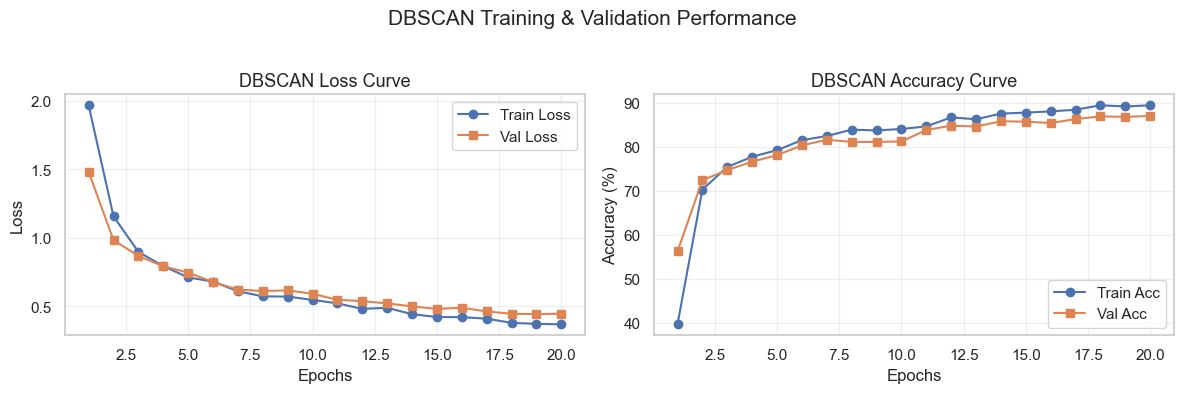

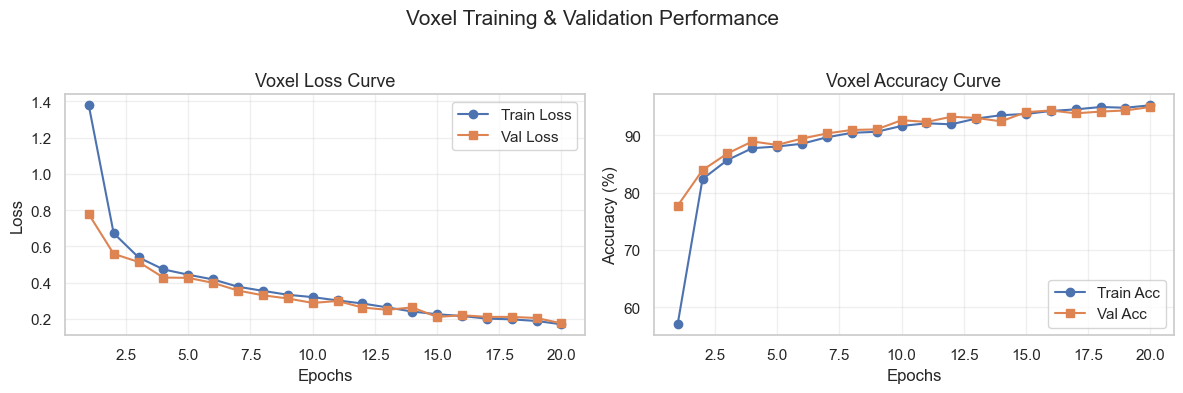

In [90]:
# -------------------------------
# Loss & Accuracy Curves
# -------------------------------
for name, info in results.items():
    history = info["history"]
    epochs = range(1, len(history["train_loss"]) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # ---- Loss Curve ----
    axes[0].plot(epochs, history["train_loss"], marker='o', label='Train Loss')
    axes[0].plot(epochs, history["val_loss"], marker='s', label='Val Loss')
    axes[0].set_title(f"{name} Loss Curve", fontsize=13)
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()

    # ---- Accuracy Curve ----
    axes[1].plot(epochs, np.array(history["train_acc"]), marker='o', label='Train Acc')
    axes[1].plot(epochs, np.array(history["val_acc"]), marker='s', label='Val Acc')
    axes[1].set_title(f"{name} Accuracy Curve", fontsize=13)
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy (%)")
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()

    plt.suptitle(f"{name} Training & Validation Performance", fontsize=15)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(f"{name}_loss_accuracy_curves.png", dpi=200)
    plt.show()

## SNN Model : Size and Inference Time Comparison

In [ ]:
# ----------------------
# CONFIG
# ----------------------
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Your saved model files
model_files = {
    "Grid": "SimpleSNN_Grid_best.pth",
    "DBSCAN": "SimpleSNN_DBSCAN_best.pth",
    "Voxel": "SimpleSNN_Voxel_best.pth"
}

results_inference = []

for name, file in model_files.items():
    print(f"\n=== Measuring {name} Model ===")

    # Load model
    model = SimpleEventSNN(time_bins=25, num_classes=10).to(device)
    model.load_state_dict(torch.load(file, map_location=device))
    model.eval()

    # Compute model size
    model_size_mb = sum(p.numel() for p in model.parameters()) * 4 / 1024 / 1024  # float32=4 bytes

    # Measure inference speed on a few batches
    test_loader = loaders[name]["test"]
    timings = []
    with torch.no_grad():
        for i, (x, y) in enumerate(test_loader):
            x = x.to(device)
            start = time.time()
            _ = model(x)
            end = time.time()
            timings.append((end - start) * 1000)  # ms
            if i == 10:  # measure only 10 batches for speed
                break

    avg_inference_ms = np.mean(timings)
    print(f"{name} | Model Size: {model_size_mb:.2f} MB | Avg Inference: {avg_inference_ms:.2f} ms")

    results_inference.append([name, f"{model_size_mb:.2f} MB", f"{avg_inference_ms:.2f} ms"])


df_inference = pd.DataFrame(results_inference, columns=["Compression Method", "Model Size (MB)", "Avg Inference / Batch (ms)"])
print("\n=== Model Size & Inference Time Summary ===")
print(df_inference.to_string(index=False))
df_inference.to_csv("model_inference_summary.csv", index=False)


=== Measuring Grid Model ===
Grid | Model Size: 4.58 MB | Avg Inference: 392.95 ms

=== Measuring DBSCAN Model ===
DBSCAN | Model Size: 4.58 MB | Avg Inference: 384.11 ms

=== Measuring Voxel Model ===
Voxel | Model Size: 4.58 MB | Avg Inference: 388.51 ms

=== Model Size & Inference Time Summary ===
Compression Method Model Size (MB) Avg Inference / Batch (ms)
              Grid         4.58 MB                  392.95 ms
            DBSCAN         4.58 MB                  384.11 ms
             Voxel         4.58 MB                  388.51 ms


## SNN Model : Evaluation


=== Evaluating Grid Dataset ===

🎯 Grid Test Accuracy: 93.45%
              precision    recall  f1-score   support

           0      0.923     0.968     0.945       186
           1      0.941     0.970     0.955       197
           2      0.924     0.924     0.924       198
           3      0.926     0.943     0.935       212
           4      0.956     0.920     0.938       212
           5      0.970     0.946     0.958       203
           6      0.964     0.960     0.962       224
           7      0.911     0.926     0.918       188
           8      0.917     0.888     0.902       187
           9      0.906     0.896     0.901       193

    accuracy                          0.934      2000
   macro avg      0.934     0.934     0.934      2000
weighted avg      0.935     0.934     0.934      2000



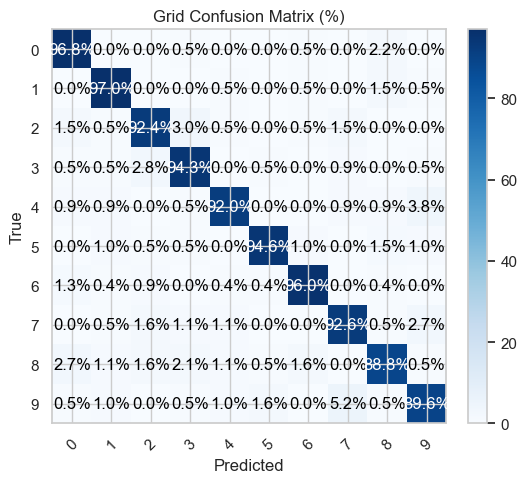


=== Evaluating DBSCAN Dataset ===

🎯 DBSCAN Test Accuracy: 88.60%
              precision    recall  f1-score   support

           0      0.872     0.925     0.897       213
           1      0.927     0.967     0.946       209
           2      0.842     0.926     0.882       190
           3      0.864     0.829     0.846       199
           4      0.909     0.904     0.906       198
           5      0.901     0.734     0.809       199
           6      0.910     0.960     0.934       200
           7      0.920     0.884     0.901       207
           8      0.837     0.846     0.842       182
           9      0.877     0.877     0.877       203

    accuracy                          0.886      2000
   macro avg      0.886     0.885     0.884      2000
weighted avg      0.887     0.886     0.885      2000



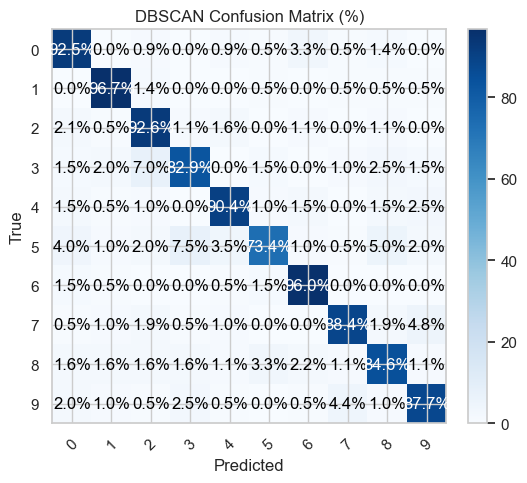


=== Evaluating Voxel Dataset ===

🎯 Voxel Test Accuracy: 95.15%
              precision    recall  f1-score   support

           0      0.971     0.967     0.969       210
           1      0.957     0.990     0.973       200
           2      0.946     0.941     0.943       186
           3      0.949     0.889     0.918       190
           4      0.935     0.973     0.953       221
           5      0.921     0.967     0.944       182
           6      0.974     0.945     0.959       200
           7      0.968     0.972     0.970       218
           8      0.934     0.934     0.934       197
           9      0.958     0.929     0.943       196

    accuracy                          0.952      2000
   macro avg      0.951     0.951     0.951      2000
weighted avg      0.952     0.952     0.951      2000



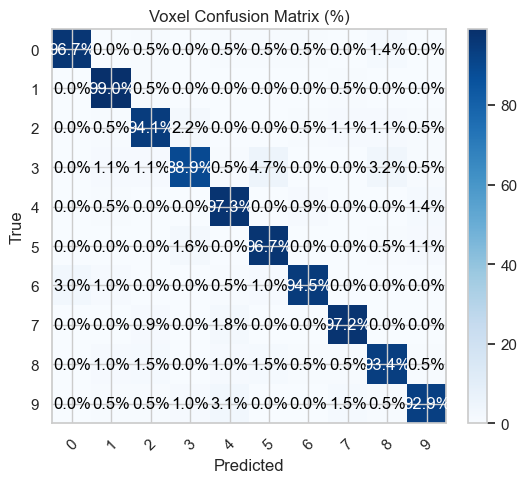


=== Final Evaluation Metrics===
Compression Method  Accuracy (%)  Precision (%)  Recall (%)  F1-Score (%)
              Grid         93.45      93.469212       93.45     93.443456
            DBSCAN         88.60      88.658369       88.60     88.497759
             Voxel         95.15      95.176665       95.15     95.137330


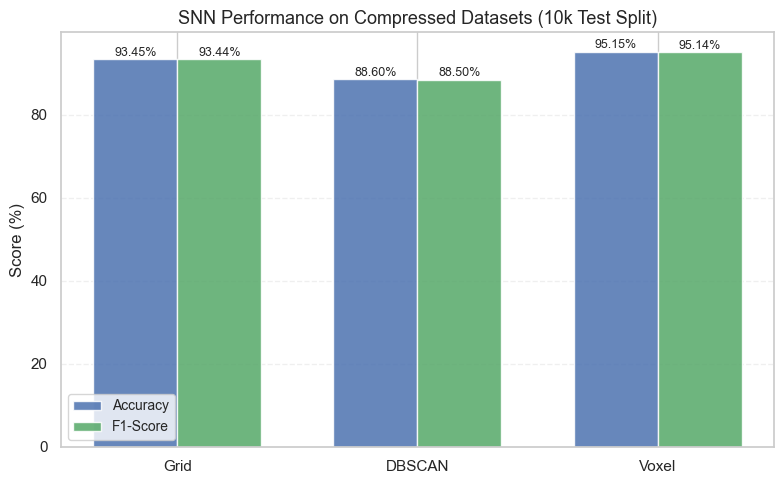

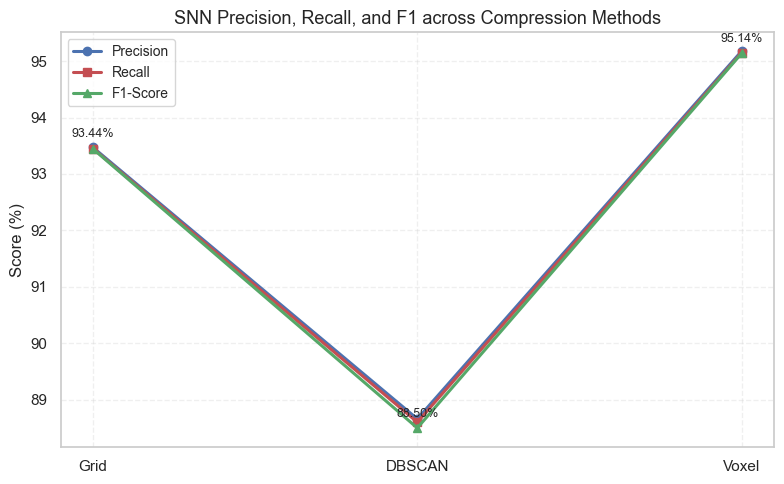

In [120]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

# ----------------------
# CONFIG
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = [str(i) for i in range(10)]  # N-MNIST classes 0-9

model_files = {
    "Grid": "SimpleSNN_Grid_best.pth",
    "DBSCAN": "SimpleSNN_DBSCAN_best.pth",
    "Voxel": "SimpleSNN_Voxel_best.pth"
}

# Directory to save reports
os.makedirs("classification_reports_snn", exist_ok=True)

# ----------------------
# Evaluation Function
# ----------------------
def evaluate_model(model, loader, name="Dataset"):
    all_preds, all_labels = [], []
    correct, total = 0, 0

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds = out.argmax(1)

            correct += (preds == y).sum().item()
            total += y.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    acc = correct / total * 100
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted'
    )

    # Classification report
    report_str = classification_report(all_labels, all_preds, digits=3)
    print(f"\n🎯 {name} Test Accuracy: {acc:.2f}%")
    print(report_str)

    # Save classification report to file
    report_path = f"classification_reports_snn/{name}_classification_report.txt"
    with open(report_path, "w") as f:
        f.write(f"=== {name} Dataset (SNN) ===\n")
        f.write(f"Accuracy: {acc:.2f}%\n\n")
        f.write(report_str)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Plot Confusion Matrix
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm_percent, cmap='Blues')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    plt.title(f"{name} Confusion Matrix (%)")
    plt.xticks(rotation=45)

    # Annotate cells
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            ax.text(j, i, f"{cm_percent[i, j]:.1f}%", ha='center', va='center',
                    color='white' if cm_percent[i, j] > 50 else 'black')

    plt.tight_layout()
    plt.savefig(f"{name}_confusion_matrix.png", dpi=200)
    plt.show()

    return acc, precision*100, recall*100, f1*100

# ----------------------
# Evaluating All Models
# ----------------------
metrics_summary = []

for name, loader_dict in loaders.items(): 
    print(f"\n=== Evaluating {name} Dataset ===")
    
    # Load model
    model = SimpleEventSNN(time_bins=25, num_classes=10).to(device)
    model.load_state_dict(torch.load(model_files[name], map_location=device))
    
    # Evaluate
    acc, prec, rec, f1 = evaluate_model(model, loader_dict["test"], name)
    metrics_summary.append([name, acc, prec, rec, f1])

# ----------------------
# Summary Table
# ----------------------
df_results = pd.DataFrame(metrics_summary, columns=["Compression Method", "Accuracy (%)", "Precision (%)", "Recall (%)", "F1-Score (%)"])
print("\n=== Final Evaluation Metrics===")
print(df_results.to_string(index=False))
# df_results.to_csv("final_detailed_metrics_summary.csv", index=False)

# ----------------------
# Improved Metric Plots
# ----------------------
methods = df_results["Compression Method"].tolist()
accuracy = df_results["Accuracy (%)"].values
f1_score = df_results["F1-Score (%)"].values
precision = df_results["Precision (%)"].values
recall = df_results["Recall (%)"].values

x = np.arange(len(methods))
width = 0.35

# Accuracy vs F1 Bar Chart
fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, accuracy, width, label="Accuracy", color="#4C72B0", alpha=0.85)
bars2 = ax.bar(x + width/2, f1_score, width, label="F1-Score", color="#55A868", alpha=0.85)

# Annotate bars
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval+0.15, f"{yval:.2f}%", 
                ha='center', va='bottom', fontsize=9)

ax.set_xticks(x)
ax.set_xticklabels(methods, fontsize=11)
ax.set_ylabel("Score (%)", fontsize=12)
ax.set_title("SNN Performance on Compressed Datasets (10k Test Split)", fontsize=13)
ax.legend(fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig("snn_accuracy_f1_improved.png", dpi=300)
plt.show()

# Precision, Recall, F1 Line Plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(methods, precision, marker='o', linestyle='-', linewidth=2.2, color="#4C72B0", label='Precision')
ax.plot(methods, recall, marker='s', linestyle='-', linewidth=2.2, color="#C44E52", label='Recall')
ax.plot(methods, f1_score, marker='^', linestyle='-', linewidth=2.2, color="#55A868", label='F1-Score')

# Annotate F1 scores
for x_i, y in enumerate(f1_score):
    ax.text(x_i, y+0.15, f"{y:.2f}%", ha='center', va='bottom', fontsize=9)

ax.set_ylabel("Score (%)", fontsize=12)
ax.set_title("SNN Precision, Recall, and F1 across Compression Methods", fontsize=13)
ax.grid(True, linestyle='--', alpha=0.3)
ax.legend(fontsize=10)
plt.tight_layout()
plt.savefig("snn_precision_recall_f1_improved.png", dpi=300)
plt.show()

## SNN Model : Compression vs Accuracy Tradeoff

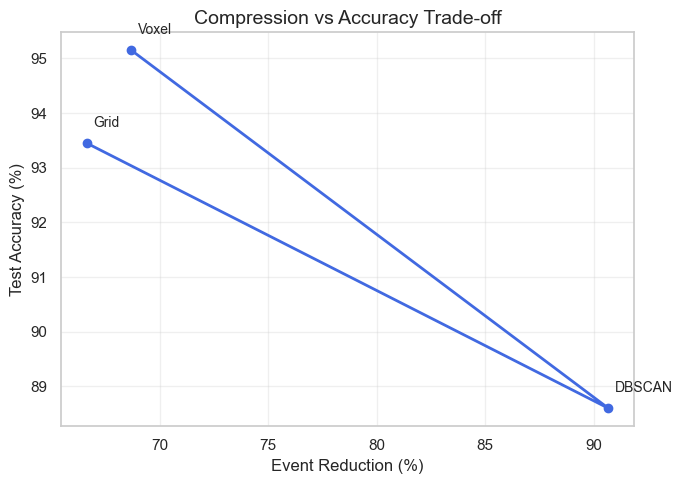

In [ ]:
# ========================
# Compression vs Accuracy Trade-off
# ========================

# Event reduction percentages
compression_summary = {
    "Grid": 66.65,
    "DBSCAN": 90.67,
    "Voxel": 68.70
}

# Extract methods, event reductions, and accuracies dynamically from df_results
methods = df_results["Compression Method"].tolist()
reductions = [compression_summary[m] for m in methods]
accuracies = df_results["Accuracy (%)"].tolist()

plt.figure(figsize=(7,5))
plt.plot(reductions, accuracies, marker='o', linewidth=2, color='royalblue')

# Annotate points with method names
for i, method in enumerate(methods):
    plt.text(reductions[i]+0.3, accuracies[i]+0.3, method, fontsize=10)

plt.title("Compression vs Accuracy Trade-off", fontsize=14)
plt.xlabel("Event Reduction (%)", fontsize=12)
plt.ylabel("Test Accuracy (%)", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("compression_vs_accuracy_tradeoff.png", dpi=200)
plt.show()

## SNN : ROC Curves

In [ ]:
# ----------------------
# CONFIG
# ----------------------
device = torch.device("cpu")
num_classes = 10
class_names = [str(i) for i in range(num_classes)]

model_files = {
    "Grid": "SimpleSNN_Grid_best.pth",
    "DBSCAN": "SimpleSNN_DBSCAN_best.pth",
    "Voxel": "SimpleSNN_Voxel_best.pth"
}

# ----------------------
# ROC Curve Function
# ----------------------
def plot_roc_for_model(model, loader, name="Dataset"):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            # ✅ Keep shape as (B, T, 2, H, W) for SimpleEventSNN
            out = model(x)  # (B,10)
            probs = torch.softmax(out, dim=1)

            all_probs.append(probs.cpu())
            all_labels.append(y.cpu())

    # Stack everything
    all_probs = torch.cat(all_probs).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Binarize labels for ROC computation
    y_bin = label_binarize(all_labels, classes=np.arange(num_classes))

    # Compute per-class ROC and AUC
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average
    fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), all_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=1,
                 label=f"Class {i} (AUC = {roc_auc[i]:.3f})")
    plt.plot(fpr["micro"], tpr["micro"], color='black', linestyle='--',
             label=f"Micro-average (AUC = {roc_auc['micro']:.3f})", lw=2)

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves - {name} Dataset")
    plt.legend(loc="lower right", fontsize=8)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"ROC_{name}.png", dpi=200)
    plt.show()

# ----------------------
# Generate ROC for all 3 models
# ----------------------
for name, model_path in model_files.items():
    print(f"\n=== Generating ROC for {name} Dataset ===")
    model = SimpleEventSNN(time_bins=25, num_classes=10).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))

    test_loader = loaders[name]["test"]  # Use your test split from 10000 samples
    plot_roc_for_model(model, test_loader, name)

## Model 2 : ConvGRU Classifier

In [107]:
class ConvGRUClassifier(nn.Module):
    def __init__(self, hidden_dim=64, num_classes=10):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(2, 16, kernel_size=3, padding=1),  # 2 → 16
            nn.ReLU(),
            nn.MaxPool2d(2),  # 34x34 → 17x17
            nn.Conv2d(16, 32, kernel_size=3, padding=1), # 16 → 32
            nn.ReLU(),
            nn.MaxPool2d(2)   # 17x17 → 8x8
        )
        self.feature_size = 32 * 8 * 8  # flattened CNN output
        self.gru = nn.GRU(input_size=self.feature_size, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x_seq):  # (T, 2, 34, 34)
        T = x_seq.shape[0]
        B = x_seq.shape[1]
        x_seq = x_seq.permute(1, 0, 2, 3, 4)  # (B, T, C, H, W)

        features = []
        for t in range(T):
            x_t = self.cnn(x_seq[:, t])             # (B, 32, 8, 8)
            features.append(x_t.view(B, -1))        # (B, feature_size)

        features = torch.stack(features, dim=1)      # (B, T, feature_size)
        _, hidden = self.gru(features)               # hidden: (1, B, hidden_dim)
        out = self.fc(hidden.squeeze(0))             # (B, num_classes)
        return out

## ConvGRU Classifier : Training Loop

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 20
lr = 1e-3
patience = 3

results = {}

for name, loader_dict in loaders.items():  
    print(f"\n=== Training ConvGRU on {name} Dataset ===")

    # Initialize model & optimizer for this dataset
    model = ConvGRUClassifier().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = F.cross_entropy

    # Track metrics
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_path = f"convgru_best_{name.lower()}.pth"

    for epoch in range(num_epochs):
        # ---------------- Training ----------------
        model.train()
        total_loss, total_correct, total_samples = 0.0, 0, 0

        progress_bar = tqdm(loader_dict["train"], desc=f"[{name}] Epoch {epoch+1}/{num_epochs}", leave=False)
        for x, y in progress_bar:
            x, y = x.to(device), y.to(device)
            x = x.permute(1, 0, 2, 3, 4)  # (T, B, 2, 34, 34)

            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_correct += (out.argmax(1) == y).sum().item()
            total_samples += y.size(0)

            progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})

        train_loss = total_loss / len(loader_dict["train"])
        train_acc = total_correct / total_samples

        # ---------------- Validation ----------------
        model.eval()
        val_loss, val_correct, val_samples = 0.0, 0, 0
        with torch.no_grad():
            for x, y in loader_dict["val"]:
                x, y = x.to(device), y.to(device)
                x = x.permute(1, 0, 2, 3, 4)

                out = model(x)
                loss = criterion(out, y)

                val_loss += loss.item()
                val_correct += (out.argmax(1) == y).sum().item()
                val_samples += y.size(0)

        val_loss_avg = val_loss / len(loader_dict["val"])
        val_acc = val_correct / val_samples

        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss_avg)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"[{name}] Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.2%} | "
              f"Val Loss: {val_loss_avg:.4f}, Acc: {val_acc:.2%}")

        # ---------------- Early Stopping ----------------
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            epochs_no_improve = 0
            torch.save(model.state_dict(), best_model_path)
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"⛔ Early stopping on {name} dataset.")
                break

    print(f"✅ Finished training {name}. Best model saved as {best_model_path}")

    # ---------------- Test Evaluation ----------------
    model.load_state_dict(torch.load(best_model_path))
    model.eval()
    test_correct, test_samples = 0, 0
    with torch.no_grad():
        for x, y in loader_dict["test"]:
            x, y = x.to(device), y.to(device)
            x = x.permute(1, 0, 2, 3, 4)
            out = model(x)
            test_correct += (out.argmax(1) == y).sum().item()
            test_samples += y.size(0)

    test_acc = test_correct / test_samples
    print(f"🎯 {name} Test Accuracy: {test_acc:.2%}")

    # Save results
    results[name] = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accs": train_accs,
        "val_accs": val_accs,
        "test_acc": test_acc,
        "best_model": best_model_path
    }

print("\nAll datasets finished training. ✅")
print({k: f"{v['test_acc']:.2%}" for k, v in results.items()})


=== Training ConvGRU on Grid Dataset ===


[Grid] Epoch 1/20 | Train Loss: 0.8002, Acc: 77.16% | Val Loss: 0.3377, Acc: 89.10%


[Grid] Epoch 2/20 | Train Loss: 0.2242, Acc: 93.60% | Val Loss: 0.2031, Acc: 93.90%


[Grid] Epoch 3/20 | Train Loss: 0.1305, Acc: 96.30% | Val Loss: 0.1526, Acc: 95.10%


[Grid] Epoch 4/20 | Train Loss: 0.0782, Acc: 97.83% | Val Loss: 0.1217, Acc: 95.90%


[Grid] Epoch 5/20 | Train Loss: 0.0517, Acc: 98.61% | Val Loss: 0.1140, Acc: 95.80%


[Grid] Epoch 6/20 | Train Loss: 0.0324, Acc: 99.11% | Val Loss: 0.1426, Acc: 95.90%


[Grid] Epoch 7/20 | Train Loss: 0.0215, Acc: 99.51% | Val Loss: 0.1009, Acc: 96.60%


[Grid] Epoch 8/20 | Train Loss: 0.0095, Acc: 99.81% | Val Loss: 0.1026, Acc: 96.60%


[Grid] Epoch 9/20 | Train Loss: 0.0043, Acc: 99.97% | Val Loss: 0.0997, Acc: 97.20%


[Grid] Epoch 10/20 | Train Loss: 0.0021, Acc: 99.99% | Val Loss: 0.0988, Acc: 97.20%


[Grid] Epoch 11/20 | Train Loss: 0.0016, Acc: 100.00% | Val Loss: 0.1023, Acc: 97.00%


[Grid] Epoch 12/20 | Train Loss: 0.0012, Acc: 100.00% | Val Loss: 0.1020, Acc: 97.00%


[Grid] Epoch 13/20 | Train Loss: 0.0010, Acc: 100.00% | Val Loss: 0.1041, Acc: 96.90%
⛔ Early stopping on Grid dataset.
✅ Finished training Grid. Best model saved as convgru_best_grid.pth
🎯 Grid Test Accuracy: 96.80%

=== Training ConvGRU on DBSCAN Dataset ===


[DBSCAN] Epoch 1/20 | Train Loss: 0.8692, Acc: 74.43% | Val Loss: 0.3507, Acc: 89.70%


[DBSCAN] Epoch 2/20 | Train Loss: 0.2625, Acc: 92.60% | Val Loss: 0.2509, Acc: 93.10%


[DBSCAN] Epoch 3/20 | Train Loss: 0.1819, Acc: 94.57% | Val Loss: 0.2305, Acc: 93.30%


[DBSCAN] Epoch 4/20 | Train Loss: 0.1351, Acc: 96.00% | Val Loss: 0.1992, Acc: 94.10%


[DBSCAN] Epoch 5/20 | Train Loss: 0.1019, Acc: 96.97% | Val Loss: 0.1890, Acc: 94.50%


[DBSCAN] Epoch 6/20 | Train Loss: 0.0769, Acc: 97.63% | Val Loss: 0.1825, Acc: 94.50%


[DBSCAN] Epoch 7/20 | Train Loss: 0.0561, Acc: 98.59% | Val Loss: 0.1758, Acc: 94.40%


[DBSCAN] Epoch 8/20 | Train Loss: 0.0407, Acc: 98.96% | Val Loss: 0.1805, Acc: 94.50%


[DBSCAN] Epoch 9/20 | Train Loss: 0.0268, Acc: 99.43% | Val Loss: 0.1778, Acc: 95.20%


[DBSCAN] Epoch 10/20 | Train Loss: 0.0183, Acc: 99.70% | Val Loss: 0.1663, Acc: 95.40%


[DBSCAN] Epoch 11/20 | Train Loss: 0.0084, Acc: 99.96% | Val Loss: 0.1746, Acc: 95.40%


[DBSCAN] Epoch 12/20 | Train Loss: 0.0052, Acc: 99.99% | Val Loss: 0.1672, Acc: 95.70%


[DBSCAN] Epoch 13/20 | Train Loss: 0.0031, Acc: 99.99% | Val Loss: 0.1634, Acc: 95.70%


[DBSCAN] Epoch 14/20 | Train Loss: 0.0022, Acc: 100.00% | Val Loss: 0.1684, Acc: 95.60%


[DBSCAN] Epoch 15/20 | Train Loss: 0.0017, Acc: 100.00% | Val Loss: 0.1690, Acc: 95.90%


[DBSCAN] Epoch 16/20 | Train Loss: 0.0013, Acc: 100.00% | Val Loss: 0.1755, Acc: 95.70%
⛔ Early stopping on DBSCAN dataset.
✅ Finished training DBSCAN. Best model saved as convgru_best_dbscan.pth
🎯 DBSCAN Test Accuracy: 95.65%

=== Training ConvGRU on Voxel Dataset ===


[Voxel] Epoch 1/20 | Train Loss: 0.9887, Acc: 68.54% | Val Loss: 0.3938, Acc: 87.30%


[Voxel] Epoch 2/20 | Train Loss: 0.2834, Acc: 91.51% | Val Loss: 0.2438, Acc: 93.80%


[Voxel] Epoch 3/20 | Train Loss: 0.1768, Acc: 94.66% | Val Loss: 0.1634, Acc: 95.20%


[Voxel] Epoch 4/20 | Train Loss: 0.1150, Acc: 96.51% | Val Loss: 0.1362, Acc: 96.40%


[Voxel] Epoch 5/20 | Train Loss: 0.0772, Acc: 97.76% | Val Loss: 0.1380, Acc: 96.00%


[Voxel] Epoch 6/20 | Train Loss: 0.0548, Acc: 98.53% | Val Loss: 0.1097, Acc: 96.90%


[Voxel] Epoch 7/20 | Train Loss: 0.0354, Acc: 98.99% | Val Loss: 0.1346, Acc: 96.20%


[Voxel] Epoch 8/20 | Train Loss: 0.0213, Acc: 99.57% | Val Loss: 0.1062, Acc: 97.20%


[Voxel] Epoch 9/20 | Train Loss: 0.0101, Acc: 99.87% | Val Loss: 0.1046, Acc: 97.50%


[Voxel] Epoch 10/20 | Train Loss: 0.0047, Acc: 100.00% | Val Loss: 0.1055, Acc: 97.40%


[Voxel] Epoch 11/20 | Train Loss: 0.0029, Acc: 100.00% | Val Loss: 0.1065, Acc: 97.30%


[Voxel] Epoch 12/20 | Train Loss: 0.0021, Acc: 100.00% | Val Loss: 0.1070, Acc: 97.50%
⛔ Early stopping on Voxel dataset.
✅ Finished training Voxel. Best model saved as convgru_best_voxel.pth
🎯 Voxel Test Accuracy: 97.60%

All datasets finished training. ✅
{'Grid': '96.80%', 'DBSCAN': '95.65%', 'Voxel': '97.60%'}


## ConvGRU Classifier : Loss & Accuracy Curve

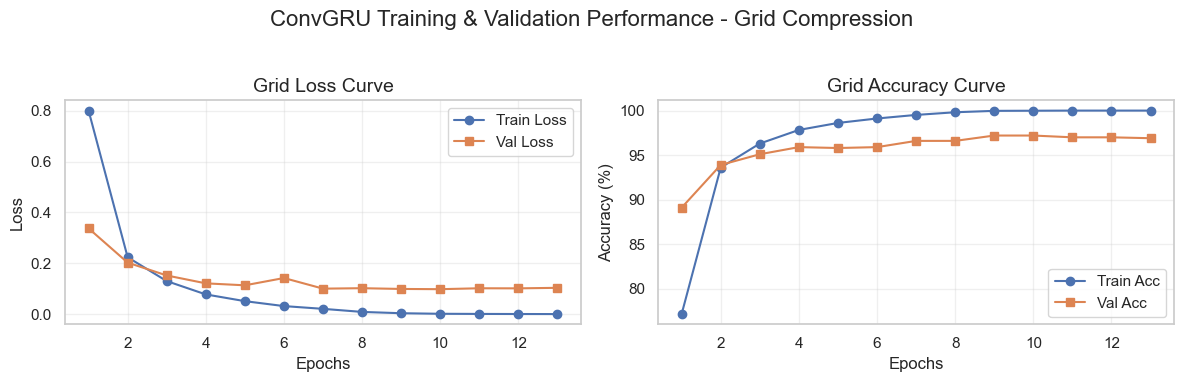

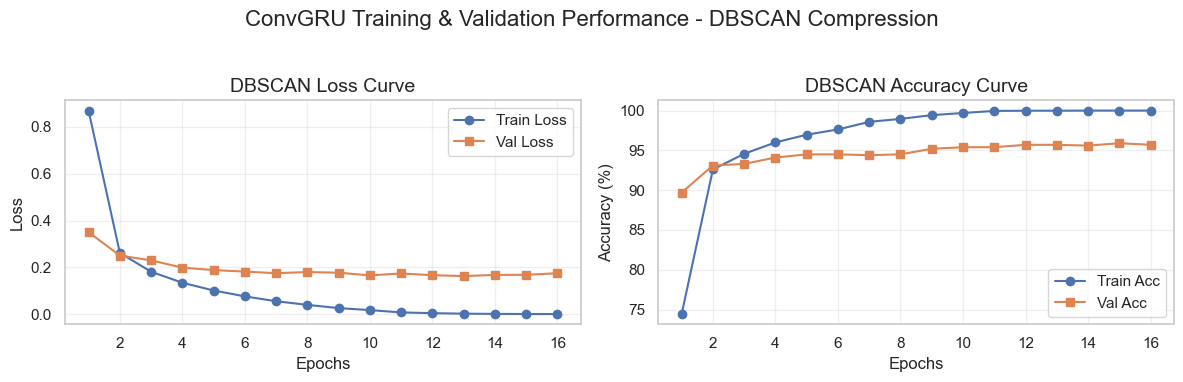

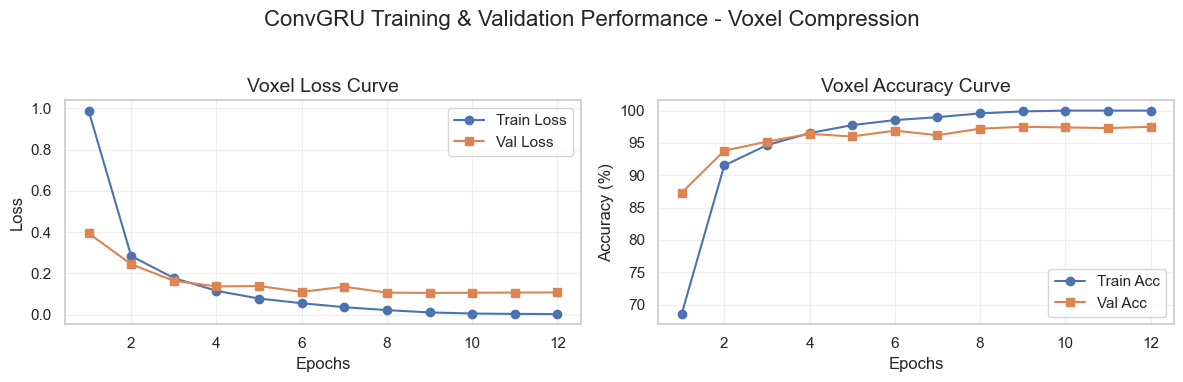

In [109]:
# -----------------------------
# Loss vs Accuracy Curves for ConvGRU
# -----------------------------
for name, metrics in results.items():
    train_losses = metrics["train_losses"]
    val_losses = metrics["val_losses"]
    train_accs = np.array(metrics["train_accs"]) * 100  # convert to %
    val_accs = np.array(metrics["val_accs"]) * 100

    epochs = np.arange(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 4))
    
    # --- Loss Curve ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", marker='o')
    plt.plot(epochs, val_losses, label="Val Loss", marker='s')
    plt.title(f"{name} Loss Curve", fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(alpha=0.3)
    plt.legend()

    # --- Accuracy Curve ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label="Train Acc", marker='o')
    plt.plot(epochs, val_accs, label="Val Acc", marker='s')
    plt.title(f"{name} Accuracy Curve", fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.grid(alpha=0.3)
    plt.legend()

    plt.suptitle(f"ConvGRU Training & Validation Performance - {name} Compression", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f"convgru_{name.lower()}_loss_acc_curves.png", dpi=200)
    plt.show()

## ConvGRU Model : Size and Inference Time Comparison

In [ ]:
# ----------------------
# CONFIG
# ----------------------
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

convgru_model_files = {
    "Grid": "convgru_best_grid.pth",
    "DBSCAN": "convgru_best_dbscan.pth",
    "Voxel": "convgru_best_voxel.pth"
}

results_convgru_inference = []

for name, file in convgru_model_files.items():
    print(f"\n=== Measuring ConvGRU {name} Model ===")

    # Load ConvGRU model
    model = ConvGRUClassifier().to(device)
    model.load_state_dict(torch.load(file, map_location=device))
    model.eval()

    model_size_mb = sum(p.numel() for p in model.parameters()) * 4 / 1024 / 1024

    # Measure inference speed on a few batches
    test_loader = loaders[name]["test"]
    timings = []
    with torch.no_grad():
        for i, (x, y) in enumerate(test_loader):
            x = x.to(device)
            x = x.permute(1, 0, 2, 3, 4)  # (T, B, 2, 34, 34) → required for ConvGRU

            start = time.time()
            _ = model(x)
            end = time.time()

            timings.append((end - start) * 1000)  # ms
            if i == 10:  # measure only first 10 batches for speed
                break

    avg_inference_ms = np.mean(timings)
    print(f"{name} | Model Size: {model_size_mb:.2f} MB | Avg Inference: {avg_inference_ms:.2f} ms")

    results_convgru_inference.append([name, f"{model_size_mb:.2f} MB", f"{avg_inference_ms:.2f} ms"])

# Save results as a clean table
df_convgru_inference = pd.DataFrame(results_convgru_inference, 
                                    columns=["Compression Method", "Model Size (MB)", "Avg Inference / Batch (ms)"])
print("\n=== ConvGRU Model Size & Inference Time Summary ===")
print(df_convgru_inference.to_string(index=False))
df_convgru_inference.to_csv("convgru_model_inference_summary.csv", index=False)


=== Measuring ConvGRU Grid Model ===
Grid | Model Size: 1.57 MB | Avg Inference: 104.35 ms

=== Measuring ConvGRU DBSCAN Model ===
DBSCAN | Model Size: 1.57 MB | Avg Inference: 110.11 ms

=== Measuring ConvGRU Voxel Model ===
Voxel | Model Size: 1.57 MB | Avg Inference: 110.66 ms

=== ConvGRU Model Size & Inference Time Summary ===
Compression Method Model Size (MB) Avg Inference / Batch (ms)
              Grid         1.57 MB                  104.35 ms
            DBSCAN         1.57 MB                  110.11 ms
             Voxel         1.57 MB                  110.66 ms


## ConvGRU Classifier : Model Evaluation


=== Evaluating ConvGRU on Grid Dataset ===

🎯 Grid Test Accuracy: 96.80%
              precision    recall  f1-score   support

           0      0.979     0.984     0.981       186
           1      0.985     0.990     0.987       197
           2      0.974     0.944     0.959       198
           3      0.967     0.972     0.969       212
           4      0.962     0.962     0.962       212
           5      0.985     0.975     0.980       203
           6      0.991     0.982     0.987       224
           7      0.942     0.952     0.947       188
           8      0.958     0.973     0.966       187
           9      0.933     0.943     0.938       193

    accuracy                          0.968      2000
   macro avg      0.968     0.968     0.968      2000
weighted avg      0.968     0.968     0.968      2000



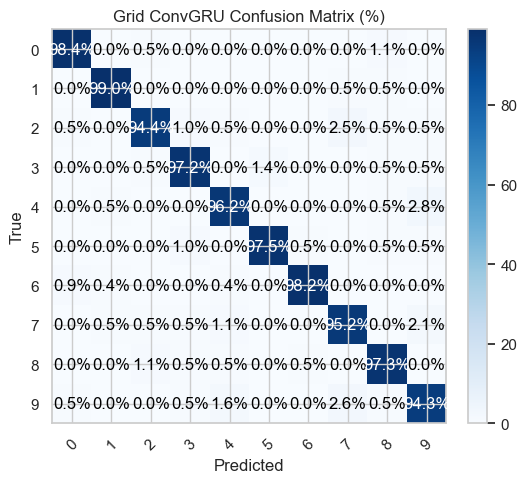


=== Evaluating ConvGRU on DBSCAN Dataset ===

🎯 DBSCAN Test Accuracy: 95.65%
              precision    recall  f1-score   support

           0      0.967     0.962     0.965       213
           1      0.986     0.976     0.981       209
           2      0.954     0.974     0.964       190
           3      0.949     0.935     0.942       199
           4      0.970     0.975     0.972       198
           5      0.949     0.945     0.947       199
           6      0.961     0.980     0.970       200
           7      0.970     0.947     0.958       207
           8      0.920     0.945     0.932       182
           9      0.935     0.926     0.931       203

    accuracy                          0.957      2000
   macro avg      0.956     0.956     0.956      2000
weighted avg      0.957     0.957     0.956      2000



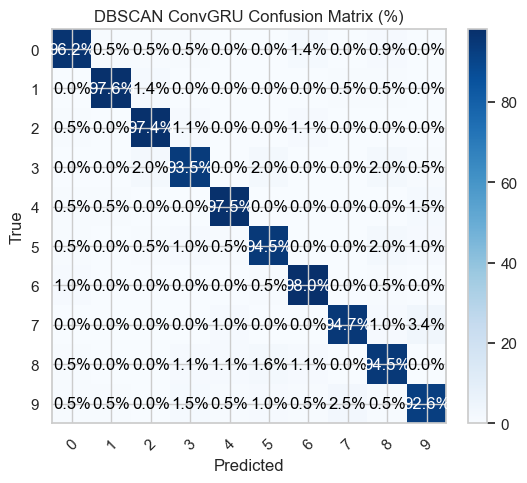


=== Evaluating ConvGRU on Voxel Dataset ===

🎯 Voxel Test Accuracy: 97.60%
              precision    recall  f1-score   support

           0      0.990     0.976     0.983       210
           1      0.952     0.995     0.973       200
           2      0.973     0.973     0.973       186
           3      0.955     0.995     0.974       190
           4      0.986     0.968     0.977       221
           5      0.994     0.967     0.981       182
           6      0.980     0.990     0.985       200
           7      0.986     0.959     0.972       218
           8      0.985     0.980     0.982       197
           9      0.959     0.959     0.959       196

    accuracy                          0.976      2000
   macro avg      0.976     0.976     0.976      2000
weighted avg      0.976     0.976     0.976      2000



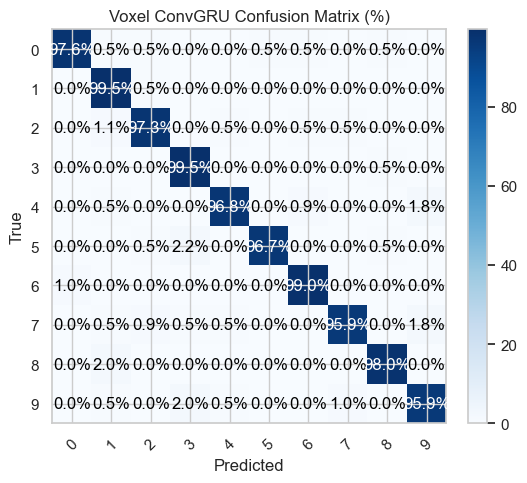


=== ConvGRU Final Evaluation Metrics===
Compression Method  Accuracy (%)  Precision (%)  Recall (%)  F1-Score (%)
              Grid         96.80      96.812036       96.80     96.802058
            DBSCAN         95.65      95.661511       95.65     95.649583
             Voxel         97.60      97.631056       97.60     97.601341


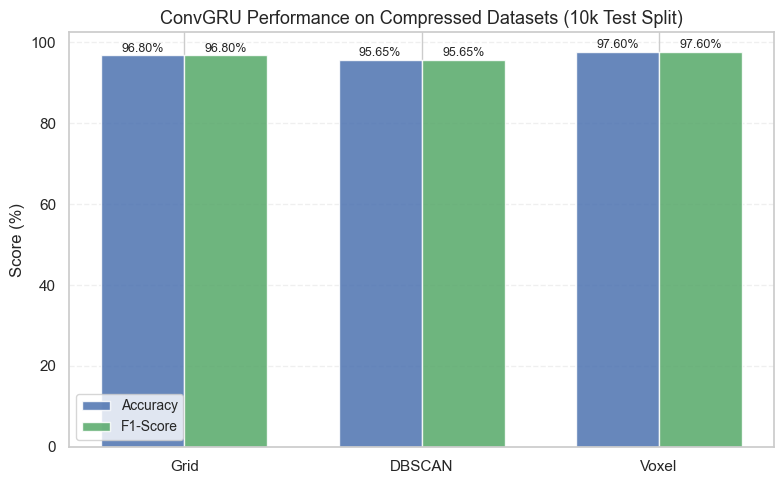

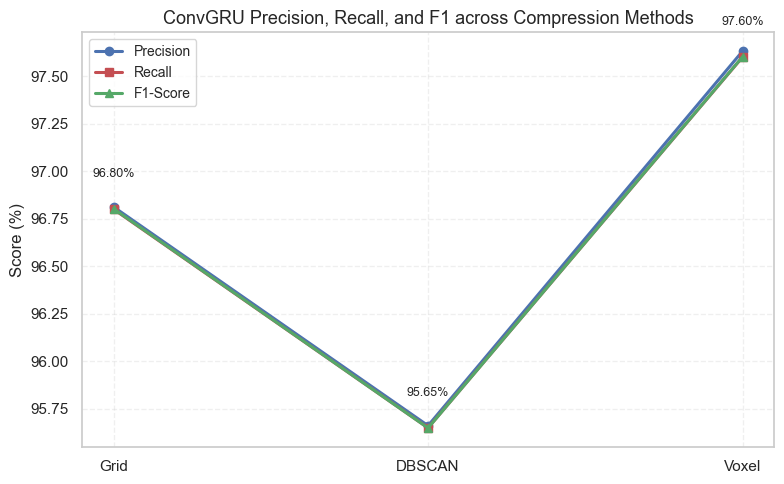

In [ ]:
# ----------------------
# CONFIG
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = [str(i) for i in range(10)]  # N-MNIST classes 0-9

# ConvGRU trained model files
convgru_model_files = {
    "Grid": "convgru_best_grid.pth",
    "DBSCAN": "convgru_best_dbscan.pth",
    "Voxel": "convgru_best_voxel.pth"
}

# Create folder to save classification reports
os.makedirs("classification_reports_convgru", exist_ok=True)

# ----------------------
# Evaluation Function
# ----------------------
def evaluate_convgru_model(model, loader, name="Dataset"):
    all_preds, all_labels = [], []
    correct, total = 0, 0

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            x = x.permute(1, 0, 2, 3, 4)  # ConvGRU expects (T,B,2,H,W)
            out = model(x)
            preds = out.argmax(1)

            correct += (preds == y).sum().item()
            total += y.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    acc = correct / total * 100
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted'
    )

    # Print and save classification report
    report_str = classification_report(all_labels, all_preds, digits=3)
    print(f"\n🎯 {name} Test Accuracy: {acc:.2f}%")
    print(report_str)

    report_path = f"classification_reports_convgru/{name}_classification_report.txt"
    with open(report_path, "w") as f:
        f.write(f"=== {name} Dataset (ConvGRU) ===\n")
        f.write(f"Accuracy: {acc:.2f}%\n\n")
        f.write(report_str)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Plot Confusion Matrix
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm_percent, cmap='Blues')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    plt.title(f"{name} ConvGRU Confusion Matrix (%)")
    plt.xticks(rotation=45)

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            ax.text(j, i, f"{cm_percent[i, j]:.1f}%", ha='center', va='center',
                    color='white' if cm_percent[i, j] > 50 else 'black')

    plt.tight_layout()
    plt.savefig(f"{name}_convgru_confusion_matrix.png", dpi=200)
    plt.show()

    return acc, precision*100, recall*100, f1*100

# ----------------------
# Evaluating All ConvGRU Models
# ----------------------
metrics_summary_convgru = []

for name, loader_dict in loaders.items(): 
    print(f"\n=== Evaluating ConvGRU on {name} Dataset ===")
    
    # Load model
    model = ConvGRUClassifier().to(device)
    model.load_state_dict(torch.load(convgru_model_files[name], map_location=device))
    
    # Evaluate
    acc, prec, rec, f1 = evaluate_convgru_model(model, loader_dict["test"], name)
    metrics_summary_convgru.append([name, acc, prec, rec, f1])

# ----------------------
# Summary Table & Save
# ----------------------
df_convgru_results = pd.DataFrame(
    metrics_summary_convgru,
    columns=["Compression Method", "Accuracy (%)", "Precision (%)", "Recall (%)", "F1-Score (%)"]
)
print("\n=== ConvGRU Final Evaluation Metrics===")
print(df_convgru_results.to_string(index=False))

df_convgru_results.to_csv("convgru_final_detailed_metrics_summary.csv", index=False)

# ----------------------
# Improved Metric Plots
# ----------------------
methods = df_convgru_results["Compression Method"].tolist()
accuracy = df_convgru_results["Accuracy (%)"].values
f1_score = df_convgru_results["F1-Score (%)"].values
precision = df_convgru_results["Precision (%)"].values
recall = df_convgru_results["Recall (%)"].values

x = np.arange(len(methods))
width = 0.35

# Accuracy vs F1 Bar Chart
fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, accuracy, width, label="Accuracy", color="#4C72B0", alpha=0.85)
bars2 = ax.bar(x + width/2, f1_score, width, label="F1-Score", color="#55A868", alpha=0.85)

for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval+0.15, f"{yval:.2f}%", 
                ha='center', va='bottom', fontsize=9)

ax.set_xticks(x)
ax.set_xticklabels(methods, fontsize=11)
ax.set_ylabel("Score (%)", fontsize=12)
ax.set_title("ConvGRU Performance on Compressed Datasets (10k Test Split)", fontsize=13)
ax.legend(fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig("convgru_accuracy_f1_improved.png", dpi=300)
plt.show()

# Precision, Recall, F1 Line Plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(methods, precision, marker='o', linestyle='-', linewidth=2.2, color="#4C72B0", label='Precision')
ax.plot(methods, recall, marker='s', linestyle='-', linewidth=2.2, color="#C44E52", label='Recall')
ax.plot(methods, f1_score, marker='^', linestyle='-', linewidth=2.2, color="#55A868", label='F1-Score')

for x_i, y in enumerate(f1_score):
    ax.text(x_i, y+0.15, f"{y:.2f}%", ha='center', va='bottom', fontsize=9)

ax.set_ylabel("Score (%)", fontsize=12)
ax.set_title("ConvGRU Precision, Recall, and F1 across Compression Methods", fontsize=13)
ax.grid(True, linestyle='--', alpha=0.3)
ax.legend(fontsize=10)
plt.tight_layout()
plt.savefig("convgru_precision_recall_f1_improved.png", dpi=300)
plt.show()

## ConvGRU : Compression vs Accuracy Tradeoff

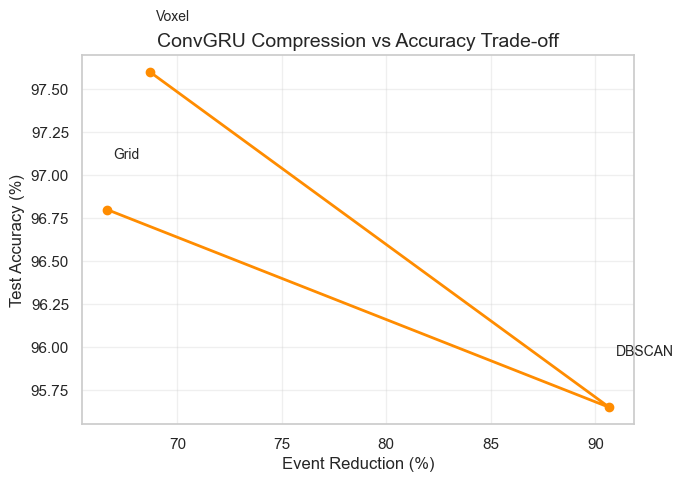

In [ ]:
# ========================
# ConvGRU Compression vs Accuracy Trade-off
# ========================

# Event reduction percentages
compression_summary = {
    "Grid": 66.65,
    "DBSCAN": 90.67,
    "Voxel": 68.70
}

# Extract methods, event reductions, and accuracies from ConvGRU evaluation results
methods = df_convgru_results["Compression Method"].tolist()
reductions = [compression_summary[m] for m in methods]
accuracies = df_convgru_results["Accuracy (%)"].tolist()

plt.figure(figsize=(7,5))
plt.plot(reductions, accuracies, marker='o', linewidth=2, color='darkorange')

# Annotate points with method names
for i, method in enumerate(methods):
    plt.text(reductions[i]+0.3, accuracies[i]+0.3, method, fontsize=10)

plt.title("ConvGRU Compression vs Accuracy Trade-off", fontsize=14)
plt.xlabel("Event Reduction (%)", fontsize=12)
plt.ylabel("Test Accuracy (%)", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("convgru_compression_vs_accuracy_tradeoff.png", dpi=200)
plt.show()

## ConvGRU : ROC Curve


=== Generating ConvGRU ROC for Grid Dataset ===


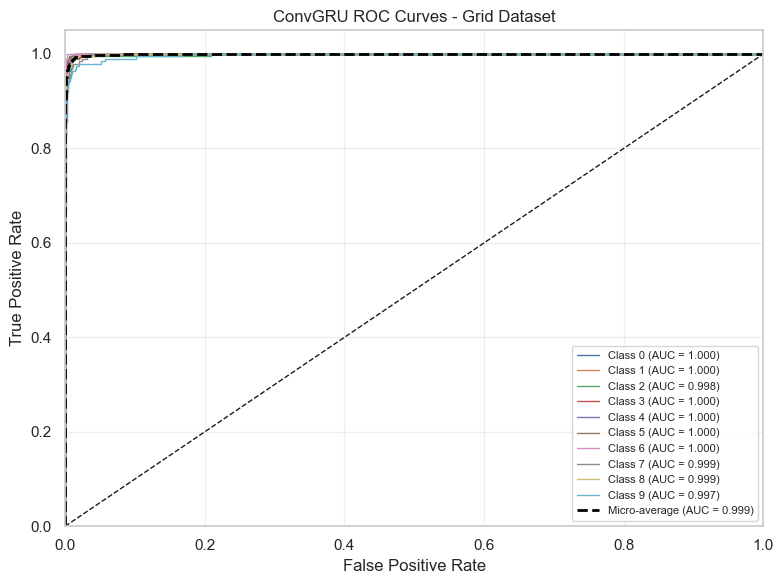


=== Generating ConvGRU ROC for DBSCAN Dataset ===


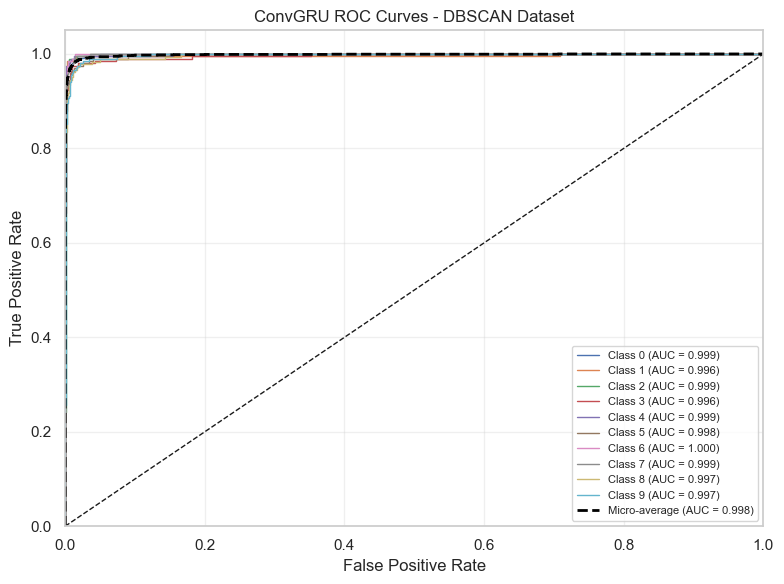


=== Generating ConvGRU ROC for Voxel Dataset ===


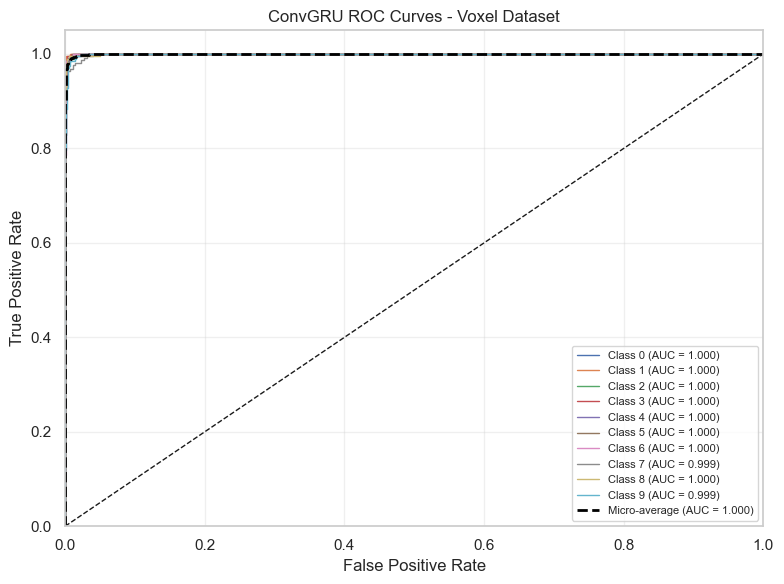

In [114]:
# ----------------------
# CONFIG
# ----------------------
device = torch.device("cpu")
num_classes = 10
class_names = [str(i) for i in range(num_classes)]

convgru_model_files = {
    "Grid": "convgru_best_grid.pth",
    "DBSCAN": "convgru_best_dbscan.pth",
    "Voxel": "convgru_best_voxel.pth"
}

# ----------------------
# ROC Curve Function for ConvGRU
# ----------------------
def plot_roc_for_convgru(model, loader, name="Dataset"):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            # ✅ ConvGRU expects (T, B, 2, H, W)
            x = x.permute(1, 0, 2, 3, 4)
            out = model(x)  # (B,10)
            probs = torch.softmax(out, dim=1)

            all_probs.append(probs.cpu())
            all_labels.append(y.cpu())

    # Stack everything
    all_probs = torch.cat(all_probs).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Binarize labels for ROC computation
    y_bin = label_binarize(all_labels, classes=np.arange(num_classes))

    # Compute per-class ROC and AUC
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average
    fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), all_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC Curves
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=1,
                 label=f"Class {i} (AUC = {roc_auc[i]:.3f})")
    plt.plot(fpr["micro"], tpr["micro"], color='black', linestyle='--',
             label=f"Micro-average (AUC = {roc_auc['micro']:.3f})", lw=2)

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ConvGRU ROC Curves - {name} Dataset")
    plt.legend(loc="lower right", fontsize=8)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"ROC_ConvGRU_{name}.png", dpi=200)
    plt.show()

# ----------------------
# Generate ROC for all 3 ConvGRU models
# ----------------------
for name, model_path in convgru_model_files.items():
    print(f"\n=== Generating ConvGRU ROC for {name} Dataset ===")
    model = ConvGRUClassifier().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))

    test_loader = loaders[name]["test"]
    plot_roc_for_convgru(model, test_loader, name)

## Comparing SNN and ConvGRU Models


===Model Comparison Table ===
Compression Method  SNN Accuracy (%)  ConvGRU Accuracy (%)  SNN F1-Score (%)  ConvGRU F1-Score (%)  SNN Precision (%)  ConvGRU Precision (%)  SNN Recall (%)  ConvGRU Recall (%)  Δ Accuracy (%)  Δ F1-Score (%)
              Grid              93.4                  96.8              93.4                  96.8               93.5                   96.8            93.4                96.8             3.4             3.4
            DBSCAN              88.6                  95.7              88.5                  95.6               88.7                   95.7            88.6                95.7             7.1             7.1
             Voxel              95.2                  97.6              95.1                  97.6               95.2                   97.6            95.2                97.6             2.4             2.5


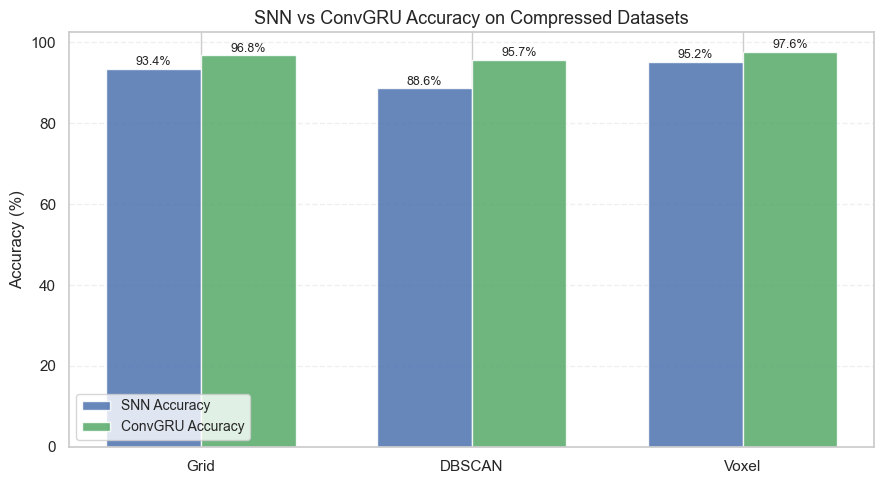

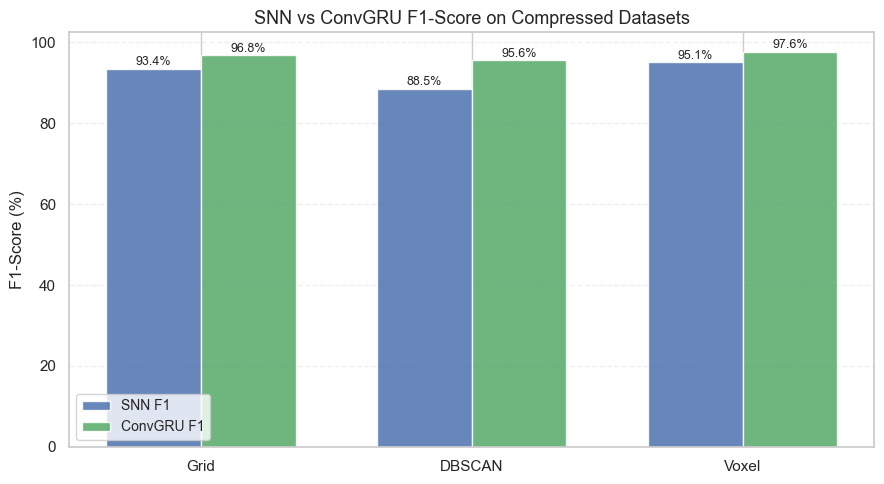

In [ ]:
# ================================
# Load combined results
# ================================
df = pd.read_csv("combined_model_comparison.csv")

# Calculate deltas
df["Δ Accuracy (%)"] = df["ConvGRU Accuracy (%)"] - df["SNN Accuracy (%)"]
df["Δ F1-Score (%)"] = df["ConvGRU F1-Score (%)"] - df["SNN F1-Score (%)"]

# Round for clean display
df_rounded = df.round(1)

print("\n===Model Comparison Table ===")
print(df_rounded.to_string(index=False))

# Save formatted table
df_rounded.to_csv("combined_model_comparison_formatted.csv", index=False)

# ================================
# 1️⃣ Grouped Bar Chart (Accuracy & F1)
# ================================
methods = df["Compression Method"].tolist()
x = range(len(methods))
width = 0.35

fig, ax = plt.subplots(figsize=(9, 5))

# Accuracy bars
bars1 = ax.bar([p - width/2 for p in x], df["SNN Accuracy (%)"], width, 
               label="SNN Accuracy", color="#4C72B0", alpha=0.85)
bars2 = ax.bar([p + width/2 for p in x], df["ConvGRU Accuracy (%)"], width, 
               label="ConvGRU Accuracy", color="#55A868", alpha=0.85)

# Annotate
for bars in [bars1, bars2]:
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()+0.15,
                f"{bar.get_height():.1f}%", ha='center', va='bottom', fontsize=9)

ax.set_xticks(x)
ax.set_xticklabels(methods, fontsize=11)
ax.set_ylabel("Accuracy (%)", fontsize=12)
ax.set_title("SNN vs ConvGRU Accuracy on Compressed Datasets", fontsize=13)
ax.legend(fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig("comparison_accuracy_bar.png", dpi=300)
plt.show()

# ================================
# 2️⃣ Grouped Bar Chart for F1-Score
# ================================
fig, ax = plt.subplots(figsize=(9, 5))
bars1 = ax.bar([p - width/2 for p in x], df["SNN F1-Score (%)"], width, 
               label="SNN F1", color="#4C72B0", alpha=0.85)
bars2 = ax.bar([p + width/2 for p in x], df["ConvGRU F1-Score (%)"], width, 
               label="ConvGRU F1", color="#55A868", alpha=0.85)

for bars in [bars1, bars2]:
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()+0.15,
                f"{bar.get_height():.1f}%", ha='center', va='bottom', fontsize=9)

ax.set_xticks(x)
ax.set_xticklabels(methods, fontsize=11)
ax.set_ylabel("F1-Score (%)", fontsize=12)
ax.set_title("SNN vs ConvGRU F1-Score on Compressed Datasets", fontsize=13)
ax.legend(fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig("comparison_f1_bar.png", dpi=300)
plt.show()